In [1]:
from classes import *
import SessionState
from sklearn.manifold import TSNE

# all plot with size = [20,16]
plt.rcParams['figure.figsize'] = [20, 16]

In [2]:

"""
Simulation parameters
"""
p_sim = {}
p_sim['n_samples'] = 1000
p_sim['n_features'] = 25
#p_sim['beta'] = [0.01 * (p_sim['n_features'] - i) / p_sim['n_features'] for i in range(0, p_sim['n_features'])]


idx = np.arange( p_sim['n_features'])
beta = (-1) ** idx * np.exp(-idx/ 10.)
beta_norm = np.linalg.norm(beta)
p_beta = 1.
p_sim['beta'] = p_beta * beta / beta_norm  #/10  (-1) ** idx * np.exp(-idx/10.)#
# select five 5 features
#p_sim['beta'] = np.array([0.1, -0.1, 0.1, -0.1, 0.1,0.1]+[0.]*(p_sim['n_features']-6))


p_sim['alpha'] = 2#1
p_sim['lamb'] = 1
p_sim['coef_tt'] = .8
p_sim['rho'] =0.5 # 0.2 #1
p_sim['kappa'] = 3.
p_sim['wd_param'] = 4. #4. # 40



p_sim['path_data'] = "./sim_surv"

"""
Model parameters
"""

p_survcaus = {}
p_survcaus['num_durations'] = 25
p_survcaus['encoded_features'] = 20
p_survcaus['alpha_wass'] = 1
p_survcaus['batch_size'] = 256
p_survcaus['epochs'] = 100
p_survcaus['lr'] = 1e-2
p_survcaus['patience'] = 10



In [3]:
nep = Neptune("test")
nep.create_experiment()
# send parameters to neptune
nep.send_dict(p_sim, "p_sim",num_run=0)
nep.experiment['beta'] = p_sim['beta']


2021-11-21 21:14:42.540 WARNING neptune.internal.hardware.gpu.gpu_monitor: Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/SurvCaus/RUNS/e/RUN-90
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [4]:
# sin(πXi1Xi2) + 2(Xi3 − 0.5)2 + Xi4 + 0.5Xi5
f1 = lambda x : np.sin(np.pi*x[:,0]*x[:,1] + 2*(x[:,2]-0.5)**2 + x[:,3] + 0.5*x[:,4])

# 2 log(1 + exp(Xi1+Xi2+Xi3 )
f2 = lambda x : np.log(1 + np.exp(x[:,0] + x[:,1] + x[:,2]))

#  (max{Xi1 + Xi2 + Xi3, 0} + max{Xi4 + Xi5, 0}) /2
f3 = lambda x : (np.maximum(x[:,0] + x[:,1] + x[:,2], 0) + np.maximum(x[:,3] + x[:,4], 0)) / 2

#  max{Xi1 + Xi2, Xi3, 0} + max{Xi4 + Xi5, 0}
f4 = lambda x : (np.maximum(x[:,0] + x[:,1], 0) - np.maximum(x[:,3] + x[:,4], 0))


p_sim['scheme'] = Scheme('linear')
#Scheme('linear') #Scheme('nonlinear',f4) # Scheme('nonlinear', f4)


In [5]:
p_survcaus, p_sim 

({'num_durations': 25,
  'encoded_features': 20,
  'alpha_wass': 1,
  'batch_size': 256,
  'epochs': 100,
  'lr': 0.01,
  'patience': 10},
 {'n_samples': 1000,
  'n_features': 25,
  'beta': array([ 0.42719892, -0.38654557,  0.34976089, -0.31647674,  0.28636   ,
         -0.25910924,  0.23445174, -0.2121407 ,  0.19195285, -0.17368612,
          0.1571577 , -0.14220217,  0.12866984, -0.11642529,  0.10534596,
         -0.09532096,  0.08624997, -0.0780422 ,  0.07061551, -0.06389555,
          0.05781509, -0.05231325,  0.04733499, -0.04283047,  0.03875461]),
  'alpha': 2,
  'lamb': 1,
  'coef_tt': 0.8,
  'rho': 0.5,
  'kappa': 3.0,
  'wd_param': 4.0,
  'path_data': './sim_surv',
  'scheme': <classes.Scheme at 0x7fecbdfe9a00>})

In [6]:
simu = SimulationNew(p_sim)
data = simu.simulation_surv()
# send data to neptune
nep.send_data(data, "data",num_run=0)
nep.experiment['Scheme'] = simu.sheme_type
nep.experiment['wd'] = simu.wd
nep.experiment['event=1'] = simu.perc_event
nep.experiment['tt=1']= simu.perc_treatement

WD =  251.90298461914062
tt = 1 : 49 % 
event = 1 : 72 %
Scheme :  linear
Wd_para :  4.0


In [7]:
data#.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X24,X25,tt,T_f_cens,event,T_1,T_0,T_f,T_cf,Xbeta
0,-1.094831,-2.050696,-2.486594,-3.060716,-2.580330,-4.548964,-3.141313,-1.923847,-1.653085,-1.691289,...,-3.860309,-2.740132,1,0.191649,1,0.191649,0.542218,0.191649,0.542218,0.973969
1,-2.598452,-1.209656,-2.161933,-2.294203,-1.038131,-1.762429,-2.604641,-1.598681,-2.044148,-2.027818,...,-1.606538,-2.300684,1,0.675848,0,0.943799,0.966047,0.943799,0.966047,-0.533218
2,-0.419284,0.753225,-0.333909,0.435053,1.326634,1.195343,1.668707,2.704299,2.879198,3.780186,...,4.206588,2.438999,0,1.434158,1,1.555483,1.434158,1.434158,1.555483,-1.448852
3,-1.174004,-1.869778,-2.653061,-1.594456,-2.614033,-2.731156,-2.913260,-3.080209,-2.296240,-1.290015,...,-3.149376,-2.817804,1,0.585816,1,0.585816,1.137295,0.585816,1.137295,0.098538
4,3.243738,1.652460,0.770501,0.989958,0.999977,2.121184,2.829137,1.632882,0.980245,2.577738,...,1.840824,1.558916,0,2.319616,1,0.875210,2.319616,2.319616,0.875210,-0.107905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.272177,1.930509,2.288973,2.301529,2.659687,1.295807,-0.046384,2.130516,1.388972,1.021334,...,1.607952,1.835531,0,0.853999,1,0.887018,0.853999,0.853999,0.887018,-0.420408
996,0.481588,1.082700,0.893099,0.619351,0.982061,2.902278,2.366550,2.116125,2.428215,2.773707,...,2.427870,2.495074,0,0.342021,1,0.624954,0.342021,0.342021,0.624954,-0.819408
997,-1.870098,-2.630034,-3.506773,-3.120112,-2.490900,-1.603128,-1.345709,-1.460898,-2.459945,-2.519502,...,-0.692957,-1.009433,1,0.238800,0,0.435694,0.591387,0.435694,0.591387,-0.108122
998,-1.445571,-0.595032,0.927506,-0.872381,-1.192296,-0.973410,-2.883070,-1.482077,-1.246072,-0.534357,...,-2.897465,-2.133606,1,0.199951,0,0.971344,1.340456,0.971344,1.340456,0.004397


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.831654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.085739


2021-11-21 21:14:59.560 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-11-21 21:14:59.561 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


[t-SNE] KL divergence after 1000 iterations: 1.655485


<ipython-input-8-e7a54b1301e3>:15: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



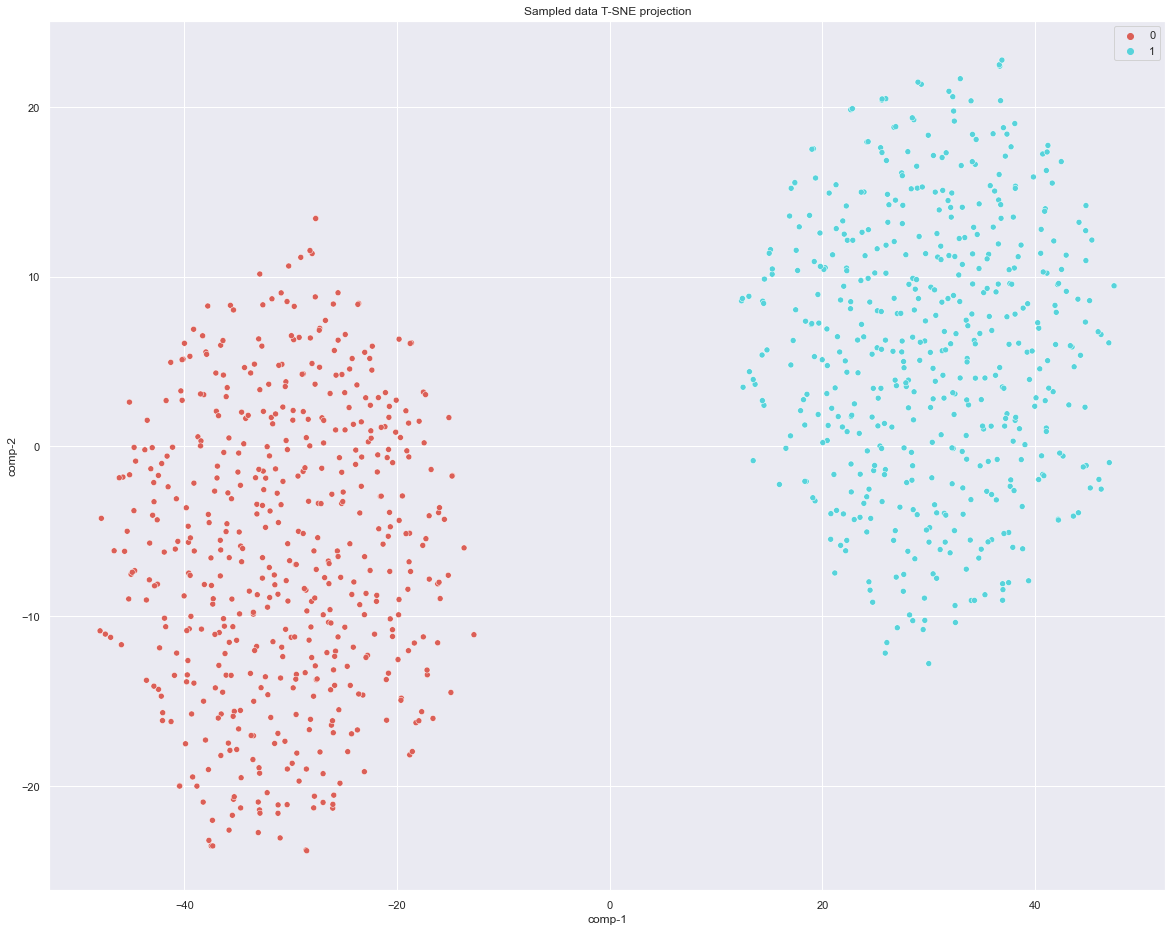

In [8]:
# TSNE

x = data.iloc[:, :p_sim['n_features']]
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
d = pd.DataFrame()
d["tt"] = data[['tt']].values.squeeze()
d["comp-1"] = z[:, 0]
d["comp-2"] = z[:, 1]

fig = plt.figure()
sns.scatterplot(x="comp-1", y="comp-2", hue=d.tt.tolist(),
            palette=sns.color_palette("hls", 2),
            data=d).set(title="Sampled data T-SNE projection")
fig.show()

# send figure to neptune
nep.send_plot(fig, "TSNE initial",num_run=0)


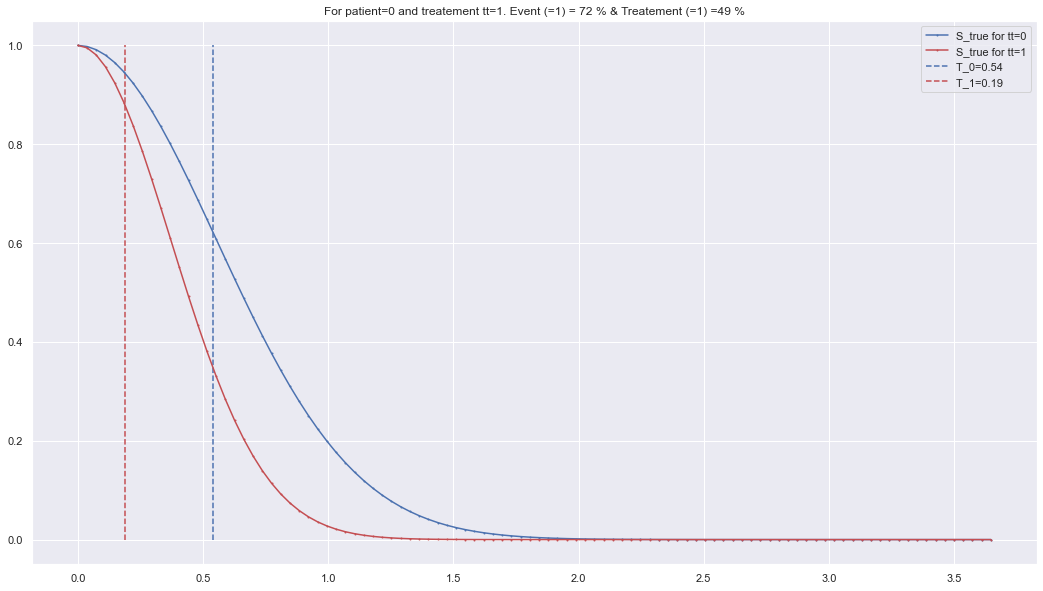

In [9]:
simu.plot_surv_true(patient=0)

# Tunning

In [10]:
#Tunning Survcaus 


tunning = Tunning(p_sim)
n_trials = 10
   
    
p_survcaus_best = tunning.get_best_hyperparameter_survcaus(n_trials=10)


[I 2021-11-21 21:15:00,476] A new study created in memory with name: no-name-56ba41f7-1073-49f2-8739-feb93e5e0171


0:	[0s / 0s],		train_loss: 2.5905,	train_loss_surv: 2.5902,	train_loss_wass: 0.0030,	val_loss: 2.6111,	val_loss_surv: 2.6105,	val_loss_wass: 0.0059
1:	[0s / 1s],		train_loss: 2.5834,	train_loss_surv: 2.5828,	train_loss_wass: 0.0065,	val_loss: 2.5912,	val_loss_surv: 2.5904,	val_loss_wass: 0.0085
2:	[1s / 2s],		train_loss: 2.5361,	train_loss_surv: 2.5348,	train_loss_wass: 0.0139,	val_loss: 2.5264,	val_loss_surv: 2.5257,	val_loss_wass: 0.0085
3:	[1s / 4s],		train_loss: 2.5152,	train_loss_surv: 2.5143,	train_loss_wass: 0.0094,	val_loss: 2.4860,	val_loss_surv: 2.4854,	val_loss_wass: 0.0064
4:	[1s / 5s],		train_loss: 2.5238,	train_loss_surv: 2.5234,	train_loss_wass: 0.0046,	val_loss: 2.4789,	val_loss_surv: 2.4785,	val_loss_wass: 0.0048
5:	[1s / 7s],		train_loss: 2.4026,	train_loss_surv: 2.4016,	train_loss_wass: 0.0106,	val_loss: 2.4812,	val_loss_surv: 2.4805,	val_loss_wass: 0.0073
6:	[1s / 8s],		train_loss: 2.4166,	train_loss_surv: 2.4159,	train_loss_wass: 0.0074,	val_loss: 2.5361,	val_loss_

  0%|          | 0/200 [00:00<?, ?it/s]

8:	[1s / 11s],		train_loss: 2.3715,	train_loss_surv: 2.3710,	train_loss_wass: 0.0059,	val_loss: 2.5609,	val_loss_surv: 2.5603,	val_loss_wass: 0.0062


100%|██████████| 200/200 [00:00<00:00, 520.75it/s]
[I 2021-11-21 21:15:12,658] Trial 0 finished with value: 0.052844318446444584 and parameters: {'num_durations': 30, 'encoded_features': 21, 'alpha_wass': 0.09340593663043201, 'lr': 0.008860944953393832}. Best is trial 0 with value: 0.052844318446444584.


0:	[0s / 0s],		train_loss: 2.4631,	train_loss_surv: 2.4630,	train_loss_wass: 0.0008,	val_loss: 2.4025,	val_loss_surv: 2.4025,	val_loss_wass: 0.0006
1:	[0s / 0s],		train_loss: 2.4555,	train_loss_surv: 2.4555,	train_loss_wass: 0.0009,	val_loss: 2.4028,	val_loss_surv: 2.4028,	val_loss_wass: 0.0006
2:	[0s / 0s],		train_loss: 2.4560,	train_loss_surv: 2.4559,	train_loss_wass: 0.0009,	val_loss: 2.4037,	val_loss_surv: 2.4036,	val_loss_wass: 0.0006


 46%|████▌     | 92/200 [00:00<00:00, 917.22it/s]

3:	[0s / 0s],		train_loss: 2.4512,	train_loss_surv: 2.4511,	train_loss_wass: 0.0008,	val_loss: 2.4044,	val_loss_surv: 2.4043,	val_loss_wass: 0.0006
4:	[0s / 0s],		train_loss: 2.3814,	train_loss_surv: 2.3813,	train_loss_wass: 0.0008,	val_loss: 2.4049,	val_loss_surv: 2.4049,	val_loss_wass: 0.0006


100%|██████████| 200/200 [00:00<00:00, 847.94it/s]
[I 2021-11-21 21:15:13,478] Trial 1 finished with value: 0.06361497436150972 and parameters: {'num_durations': 21, 'encoded_features': 19, 'alpha_wass': 0.0670846086975257, 'lr': 0.000108472577813243}. Best is trial 0 with value: 0.052844318446444584.


0:	[0s / 0s],		train_loss: 2.3255,	train_loss_surv: 2.3255,	train_loss_wass: 0.0004,	val_loss: 2.3844,	val_loss_surv: 2.3844,	val_loss_wass: 0.0004
1:	[0s / 0s],		train_loss: 2.2444,	train_loss_surv: 2.2444,	train_loss_wass: 0.0004,	val_loss: 2.3736,	val_loss_surv: 2.3736,	val_loss_wass: 0.0004
2:	[0s / 0s],		train_loss: 2.1957,	train_loss_surv: 2.1957,	train_loss_wass: 0.0005,	val_loss: 2.3577,	val_loss_surv: 2.3577,	val_loss_wass: 0.0003
3:	[0s / 0s],		train_loss: 2.1747,	train_loss_surv: 2.1747,	train_loss_wass: 0.0002,	val_loss: 2.3417,	val_loss_surv: 2.3417,	val_loss_wass: 0.0003
4:	[0s / 0s],		train_loss: 2.1279,	train_loss_surv: 2.1279,	train_loss_wass: 0.0003,	val_loss: 2.3291,	val_loss_surv: 2.3291,	val_loss_wass: 0.0003
5:	[0s / 0s],		train_loss: 2.1200,	train_loss_surv: 2.1200,	train_loss_wass: 0.0002,	val_loss: 2.3209,	val_loss_surv: 2.3209,	val_loss_wass: 0.0002
6:	[0s / 0s],		train_loss: 2.1663,	train_loss_surv: 2.1663,	train_loss_wass: 0.0002,	val_loss: 2.3145,	val_loss_

 47%|████▋     | 94/200 [00:00<00:00, 932.50it/s]

18:	[0s / 2s],		train_loss: 1.8658,	train_loss_surv: 1.8658,	train_loss_wass: 0.0003,	val_loss: 2.3074,	val_loss_surv: 2.3074,	val_loss_wass: 0.0003


100%|██████████| 200/200 [00:00<00:00, 978.45it/s]
[I 2021-11-21 21:15:15,905] Trial 2 finished with value: 0.04139132762791576 and parameters: {'num_durations': 20, 'encoded_features': 17, 'alpha_wass': 0.04033095070840015, 'lr': 0.00307156879044142}. Best is trial 2 with value: 0.04139132762791576.


0:	[0s / 0s],		train_loss: 2.5687,	train_loss_surv: 2.5686,	train_loss_wass: 0.0011,	val_loss: 2.4875,	val_loss_surv: 2.4875,	val_loss_wass: 0.0010
1:	[0s / 0s],		train_loss: 2.4727,	train_loss_surv: 2.4726,	train_loss_wass: 0.0012,	val_loss: 2.4843,	val_loss_surv: 2.4842,	val_loss_wass: 0.0009
2:	[0s / 0s],		train_loss: 2.3847,	train_loss_surv: 2.3846,	train_loss_wass: 0.0010,	val_loss: 2.4781,	val_loss_surv: 2.4780,	val_loss_wass: 0.0008
3:	[0s / 0s],		train_loss: 2.3367,	train_loss_surv: 2.3367,	train_loss_wass: 0.0009,	val_loss: 2.4697,	val_loss_surv: 2.4696,	val_loss_wass: 0.0008
4:	[0s / 0s],		train_loss: 2.3215,	train_loss_surv: 2.3215,	train_loss_wass: 0.0009,	val_loss: 2.4585,	val_loss_surv: 2.4584,	val_loss_wass: 0.0008
5:	[0s / 0s],		train_loss: 2.2502,	train_loss_surv: 2.2501,	train_loss_wass: 0.0011,	val_loss: 2.4434,	val_loss_surv: 2.4434,	val_loss_wass: 0.0009
6:	[0s / 0s],		train_loss: 2.2472,	train_loss_surv: 2.2472,	train_loss_wass: 0.0009,	val_loss: 2.4319,	val_loss_

  0%|          | 0/200 [00:00<?, ?it/s]

18:	[0s / 2s],		train_loss: 1.8970,	train_loss_surv: 1.8969,	train_loss_wass: 0.0007,	val_loss: 2.3985,	val_loss_surv: 2.3985,	val_loss_wass: 0.0005
19:	[0s / 2s],		train_loss: 1.8808,	train_loss_surv: 1.8808,	train_loss_wass: 0.0006,	val_loss: 2.3969,	val_loss_surv: 2.3969,	val_loss_wass: 0.0005


100%|██████████| 200/200 [00:00<00:00, 945.65it/s]
[I 2021-11-21 21:15:18,436] Trial 3 finished with value: 0.03988560305983323 and parameters: {'num_durations': 25, 'encoded_features': 16, 'alpha_wass': 0.05301474692905854, 'lr': 0.0021375242019003047}. Best is trial 3 with value: 0.03988560305983323.


0:	[0s / 0s],		train_loss: 2.3262,	train_loss_surv: 2.3261,	train_loss_wass: 0.0020,	val_loss: 2.3463,	val_loss_surv: 2.3462,	val_loss_wass: 0.0019
1:	[0s / 0s],		train_loss: 2.3618,	train_loss_surv: 2.3617,	train_loss_wass: 0.0023,	val_loss: 2.3447,	val_loss_surv: 2.3446,	val_loss_wass: 0.0020
2:	[0s / 1s],		train_loss: 2.2702,	train_loss_surv: 2.2701,	train_loss_wass: 0.0024,	val_loss: 2.3418,	val_loss_surv: 2.3417,	val_loss_wass: 0.0021
3:	[0s / 1s],		train_loss: 2.2405,	train_loss_surv: 2.2404,	train_loss_wass: 0.0029,	val_loss: 2.3372,	val_loss_surv: 2.3371,	val_loss_wass: 0.0022
4:	[0s / 1s],		train_loss: 2.2280,	train_loss_surv: 2.2279,	train_loss_wass: 0.0026,	val_loss: 2.3311,	val_loss_surv: 2.3311,	val_loss_wass: 0.0021
5:	[0s / 2s],		train_loss: 2.2114,	train_loss_surv: 2.2113,	train_loss_wass: 0.0022,	val_loss: 2.3241,	val_loss_surv: 2.3240,	val_loss_wass: 0.0020
6:	[0s / 2s],		train_loss: 2.1677,	train_loss_surv: 2.1677,	train_loss_wass: 0.0024,	val_loss: 2.3160,	val_loss_

 36%|███▋      | 73/200 [00:00<00:00, 729.02it/s]

19:	[0s / 7s],		train_loss: 1.9467,	train_loss_surv: 1.9466,	train_loss_wass: 0.0020,	val_loss: 2.2169,	val_loss_surv: 2.2168,	val_loss_wass: 0.0015


100%|██████████| 200/200 [00:00<00:00, 758.33it/s]
[I 2021-11-21 21:15:26,177] Trial 4 finished with value: 0.04860886353693633 and parameters: {'num_durations': 20, 'encoded_features': 20, 'alpha_wass': 0.022074500482491266, 'lr': 0.0010034995084513539}. Best is trial 3 with value: 0.03988560305983323.


0:	[0s / 0s],		train_loss: 2.4868,	train_loss_surv: 2.4868,	train_loss_wass: 0.0019,	val_loss: 2.4166,	val_loss_surv: 2.4165,	val_loss_wass: 0.0042
1:	[0s / 0s],		train_loss: 2.3097,	train_loss_surv: 2.3096,	train_loss_wass: 0.0048,	val_loss: 2.3733,	val_loss_surv: 2.3733,	val_loss_wass: 0.0039
2:	[1s / 1s],		train_loss: 2.3253,	train_loss_surv: 2.3251,	train_loss_wass: 0.0063,	val_loss: 2.3507,	val_loss_surv: 2.3506,	val_loss_wass: 0.0066
3:	[1s / 3s],		train_loss: 2.2812,	train_loss_surv: 2.2810,	train_loss_wass: 0.0108,	val_loss: 2.3422,	val_loss_surv: 2.3420,	val_loss_wass: 0.0075
4:	[1s / 4s],		train_loss: 2.2827,	train_loss_surv: 2.2825,	train_loss_wass: 0.0092,	val_loss: 2.3346,	val_loss_surv: 2.3344,	val_loss_wass: 0.0070
5:	[0s / 5s],		train_loss: 2.2708,	train_loss_surv: 2.2705,	train_loss_wass: 0.0108,	val_loss: 2.3114,	val_loss_surv: 2.3113,	val_loss_wass: 0.0080
6:	[0s / 6s],		train_loss: 2.3038,	train_loss_surv: 2.3036,	train_loss_wass: 0.0090,	val_loss: 2.3316,	val_loss_

 28%|██▊       | 56/200 [00:00<00:00, 552.95it/s]

9:	[0s / 8s],		train_loss: 2.1381,	train_loss_surv: 2.1380,	train_loss_wass: 0.0041,	val_loss: 2.4072,	val_loss_surv: 2.4071,	val_loss_wass: 0.0038


100%|██████████| 200/200 [00:00<00:00, 666.64it/s]
[I 2021-11-21 21:15:35,408] Trial 5 finished with value: 0.03976848234703354 and parameters: {'num_durations': 23, 'encoded_features': 12, 'alpha_wass': 0.022579719563762885, 'lr': 0.009982664269815218}. Best is trial 5 with value: 0.03976848234703354.


0:	[0s / 0s],		train_loss: 2.5679,	train_loss_surv: 2.5679,	train_loss_wass: 0.0008,	val_loss: 2.6544,	val_loss_surv: 2.6543,	val_loss_wass: 0.0010
1:	[0s / 0s],		train_loss: 2.5395,	train_loss_surv: 2.5393,	train_loss_wass: 0.0023,	val_loss: 2.6433,	val_loss_surv: 2.6431,	val_loss_wass: 0.0032
2:	[0s / 0s],		train_loss: 2.4807,	train_loss_surv: 2.4804,	train_loss_wass: 0.0048,	val_loss: 2.6271,	val_loss_surv: 2.6268,	val_loss_wass: 0.0041
3:	[0s / 1s],		train_loss: 2.4696,	train_loss_surv: 2.4692,	train_loss_wass: 0.0047,	val_loss: 2.6115,	val_loss_surv: 2.6112,	val_loss_wass: 0.0037
4:	[0s / 2s],		train_loss: 2.4048,	train_loss_surv: 2.4044,	train_loss_wass: 0.0048,	val_loss: 2.6055,	val_loss_surv: 2.6052,	val_loss_wass: 0.0036
5:	[1s / 3s],		train_loss: 2.3723,	train_loss_surv: 2.3719,	train_loss_wass: 0.0052,	val_loss: 2.5905,	val_loss_surv: 2.5902,	val_loss_wass: 0.0035
6:	[1s / 5s],		train_loss: 2.3562,	train_loss_surv: 2.3559,	train_loss_wass: 0.0046,	val_loss: 2.5766,	val_loss_

  0%|          | 0/200 [00:00<?, ?it/s]

13:	[0s / 10s],		train_loss: 2.1806,	train_loss_surv: 2.1804,	train_loss_wass: 0.0032,	val_loss: 2.6073,	val_loss_surv: 2.6072,	val_loss_wass: 0.0021


100%|██████████| 200/200 [00:00<00:00, 566.60it/s]
[I 2021-11-21 21:15:46,229] Trial 6 finished with value: 0.03968108678226207 and parameters: {'num_durations': 28, 'encoded_features': 16, 'alpha_wass': 0.07085343609913596, 'lr': 0.004755075155274193}. Best is trial 6 with value: 0.03968108678226207.


0:	:53s / 1m:53s],		train_loss: 2.4843,	train_loss_surv: 2.4842,	train_loss_wass: 0.0007,	val_loss: 2.5816,	val_loss_surv: 2.5815,	val_loss_wass: 0.0006
1:	[0s / 1m:54s],		train_loss: 2.4208,	train_loss_surv: 2.4208,	train_loss_wass: 0.0008,	val_loss: 2.5820,	val_loss_surv: 2.5820,	val_loss_wass: 0.0006
2:	[0s / 1m:54s],		train_loss: 2.4013,	train_loss_surv: 2.4013,	train_loss_wass: 0.0009,	val_loss: 2.5834,	val_loss_surv: 2.5833,	val_loss_wass: 0.0006
3:	[0s / 1m:55s],		train_loss: 2.4426,	train_loss_surv: 2.4426,	train_loss_wass: 0.0009,	val_loss: 2.5849,	val_loss_surv: 2.5848,	val_loss_wass: 0.0007


  0%|          | 0/200 [00:00<?, ?it/s]

4:	[0s / 1m:55s],		train_loss: 2.3725,	train_loss_surv: 2.3725,	train_loss_wass: 0.0009,	val_loss: 2.5864,	val_loss_surv: 2.5864,	val_loss_wass: 0.0007


100%|██████████| 200/200 [00:00<00:00, 460.12it/s]
[I 2021-11-21 21:17:42,834] Trial 7 finished with value: 0.06270299861488149 and parameters: {'num_durations': 24, 'encoded_features': 18, 'alpha_wass': 0.03341483323450152, 'lr': 0.000527332024214509}. Best is trial 6 with value: 0.03968108678226207.


0:	[0s / 0s],		train_loss: 2.5985,	train_loss_surv: 2.5985,	train_loss_wass: 0.0014,	val_loss: 2.7298,	val_loss_surv: 2.7297,	val_loss_wass: 0.0020
1:	[0s / 1s],		train_loss: 2.5057,	train_loss_surv: 2.5056,	train_loss_wass: 0.0028,	val_loss: 2.7239,	val_loss_surv: 2.7238,	val_loss_wass: 0.0033
2:	[0s / 1s],		train_loss: 2.4451,	train_loss_surv: 2.4450,	train_loss_wass: 0.0039,	val_loss: 2.7163,	val_loss_surv: 2.7162,	val_loss_wass: 0.0043
3:	[0s / 2s],		train_loss: 2.4197,	train_loss_surv: 2.4195,	train_loss_wass: 0.0063,	val_loss: 2.7063,	val_loss_surv: 2.7061,	val_loss_wass: 0.0043
4:	[0s / 3s],		train_loss: 2.3843,	train_loss_surv: 2.3841,	train_loss_wass: 0.0057,	val_loss: 2.6940,	val_loss_surv: 2.6938,	val_loss_wass: 0.0041
5:	[0s / 3s],		train_loss: 2.3163,	train_loss_surv: 2.3161,	train_loss_wass: 0.0045,	val_loss: 2.6818,	val_loss_surv: 2.6817,	val_loss_wass: 0.0034
6:	[0s / 4s],		train_loss: 2.3450,	train_loss_surv: 2.3448,	train_loss_wass: 0.0039,	val_loss: 2.6791,	val_loss_

 48%|████▊     | 97/200 [00:00<00:00, 964.50it/s]

16:	[0s / 9s],		train_loss: 1.9589,	train_loss_surv: 1.9588,	train_loss_wass: 0.0016,	val_loss: 2.6740,	val_loss_surv: 2.6739,	val_loss_wass: 0.0018


100%|██████████| 200/200 [00:00<00:00, 988.37it/s]
[I 2021-11-21 21:17:52,443] Trial 8 finished with value: 0.04351884090423249 and parameters: {'num_durations': 27, 'encoded_features': 26, 'alpha_wass': 0.0374064597633434, 'lr': 0.0044746027798376236}. Best is trial 6 with value: 0.03968108678226207.


0:	[0s / 0s],		train_loss: 2.5925,	train_loss_surv: 2.5925,	train_loss_wass: 0.0010,	val_loss: 2.5697,	val_loss_surv: 2.5697,	val_loss_wass: 0.0007
1:	[0s / 0s],		train_loss: 2.5273,	train_loss_surv: 2.5273,	train_loss_wass: 0.0010,	val_loss: 2.5690,	val_loss_surv: 2.5690,	val_loss_wass: 0.0008
2:	[0s / 0s],		train_loss: 2.4801,	train_loss_surv: 2.4800,	train_loss_wass: 0.0010,	val_loss: 2.5674,	val_loss_surv: 2.5674,	val_loss_wass: 0.0007
3:	[0s / 0s],		train_loss: 2.5116,	train_loss_surv: 2.5115,	train_loss_wass: 0.0011,	val_loss: 2.5648,	val_loss_surv: 2.5648,	val_loss_wass: 0.0006
4:	[0s / 1s],		train_loss: 2.4417,	train_loss_surv: 2.4417,	train_loss_wass: 0.0007,	val_loss: 2.5619,	val_loss_surv: 2.5619,	val_loss_wass: 0.0005
5:	[0s / 1s],		train_loss: 2.4271,	train_loss_surv: 2.4271,	train_loss_wass: 0.0008,	val_loss: 2.5591,	val_loss_surv: 2.5591,	val_loss_wass: 0.0004
6:	[0s / 1s],		train_loss: 2.3726,	train_loss_surv: 2.3726,	train_loss_wass: 0.0007,	val_loss: 2.5569,	val_loss_

 35%|███▌      | 70/200 [00:00<00:00, 691.59it/s]

19:	[0s / 4s],		train_loss: 2.0909,	train_loss_surv: 2.0909,	train_loss_wass: 0.0007,	val_loss: 2.4796,	val_loss_surv: 2.4796,	val_loss_wass: 0.0004


100%|██████████| 200/200 [00:00<00:00, 602.81it/s]
[I 2021-11-21 21:17:57,123] Trial 9 finished with value: 0.04251237410147566 and parameters: {'num_durations': 27, 'encoded_features': 18, 'alpha_wass': 0.018295996165200498, 'lr': 0.0012524800893543872}. Best is trial 6 with value: 0.03968108678226207.


In [11]:
# Tunning BART 

p_bart_best = tunning.get_best_hyperparameter_bart(n_trials=1)
            

[I 2021-11-21 21:17:57,233] A new study created in memory with name: no-name-b7065b92-83da-4df3-9ae0-554c4c6facf9
100%|██████████| 200/200 [00:03<00:00, 63.14it/s] 
[I 2021-11-21 21:18:01,035] Trial 0 finished with value: 0.05179902111977253 and parameters: {'num_trees': 28, 'max_features': 'sqrt', 'max_depth': 8, 'alpha': 0.0973053970730929}. Best is trial 0 with value: 0.05179902111977253.


# Training 

In [12]:

p_survcaus = p_survcaus_best.copy()

p_survcaus['patience'] = 2
p_survcaus['epochs'] = 20
p_survcaus['batch_size'] = 256
p_survcaus['num_durations'] = 25 #20
p_survcaus['encoded_features'] =12
    
print("Best hyperparameter for survcaus : ", p_survcaus)
print("Best hyperparameter for BART : ", p_bart_best)
    
Ev = Evaluation(p_sim, p_survcaus)


list_models =  ["SurvCaus", "SurvCaus_0",'BART', 'CoxPH','DeepSurv','EST','RSF']
print("Choosed models : ", list_models)

nep.send_dict(p_survcaus, "p_survcaus",num_run=0)
nep.send_dict(p_bart_best, "p_bart_best",num_run=0)

Best hyperparameter for survcaus :  {'num_durations': 25, 'encoded_features': 12, 'alpha_wass': 0.07085343609913596, 'lr': 0.004755075155274193, 'patience': 2, 'epochs': 20, 'batch_size': 256}
Best hyperparameter for BART :  {'num_trees': 28, 'max_features': 'sqrt', 'max_depth': 8, 'alpha': 0.0973053970730929}
Choosed models :  ['SurvCaus', 'SurvCaus_0', 'BART', 'CoxPH', 'DeepSurv', 'EST', 'RSF']


SurvCaus
{'num_durations': 25, 'encoded_features': 12, 'alpha_wass': 0.07085343609913596, 'lr': 0.004755075155274193, 'patience': 2, 'epochs': 20, 'batch_size': 256}
0:	[4s / 4s],		train_loss: 2.5373,	train_loss_surv: 2.5373,	train_loss_wass: 0.0010,	val_loss: 2.5000,	val_loss_surv: 2.4999,	val_loss_wass: 0.0008
1:	[0s / 4s],		train_loss: 2.3990,	train_loss_surv: 2.3989,	train_loss_wass: 0.0011,	val_loss: 2.4916,	val_loss_surv: 2.4915,	val_loss_wass: 0.0010
2:	[0s / 5s],		train_loss: 2.3658,	train_loss_surv: 2.3657,	train_loss_wass: 0.0014,	val_loss: 2.4721,	val_loss_surv: 2.4720,	val_loss_wass: 0.0013
3:	[0s / 5s],		train_loss: 2.3892,	train_loss_surv: 2.3891,	train_loss_wass: 0.0018,	val_loss: 2.4591,	val_loss_surv: 2.4590,	val_loss_wass: 0.0017
4:	[0s / 6s],		train_loss: 2.3238,	train_loss_surv: 2.3236,	train_loss_wass: 0.0023,	val_loss: 2.4510,	val_loss_surv: 2.4508,	val_loss_wass: 0.0026
5:	[1s / 8s],		train_loss: 2.3206,	train_loss_surv: 2.3204,	train_loss_wass: 0.0037,	val_loss:

 47%|████▋     | 94/200 [00:00<00:00, 934.08it/s]

13:	[0s / 18s],		train_loss: 2.0011,	train_loss_surv: 2.0010,	train_loss_wass: 0.0019,	val_loss: 2.4145,	val_loss_surv: 2.4143,	val_loss_wass: 0.0020


100%|██████████| 200/200 [00:00<00:00, 956.91it/s]


SurvCaus_0
{'num_durations': 25, 'encoded_features': 12, 'alpha_wass': 0.0, 'lr': 0.004755075155274193, 'patience': 2, 'epochs': 20, 'batch_size': 256}
0:	[0s / 0s],		train_loss: 2.5380,	train_loss_surv: 2.5380,	train_loss_wass: 0.0011,	val_loss: 2.5605,	val_loss_surv: 2.5605,	val_loss_wass: 0.0012
1:	[0s / 0s],		train_loss: 2.4014,	train_loss_surv: 2.4014,	train_loss_wass: 0.0023,	val_loss: 2.5513,	val_loss_surv: 2.5513,	val_loss_wass: 0.0020
2:	[0s / 0s],		train_loss: 2.3820,	train_loss_surv: 2.3820,	train_loss_wass: 0.0033,	val_loss: 2.5351,	val_loss_surv: 2.5351,	val_loss_wass: 0.0023
3:	[0s / 1s],		train_loss: 2.3553,	train_loss_surv: 2.3553,	train_loss_wass: 0.0029,	val_loss: 2.5189,	val_loss_surv: 2.5189,	val_loss_wass: 0.0020
4:	[0s / 1s],		train_loss: 2.3125,	train_loss_surv: 2.3125,	train_loss_wass: 0.0020,	val_loss: 2.5077,	val_loss_surv: 2.5077,	val_loss_wass: 0.0012
5:	[0s / 1s],		train_loss: 2.2795,	train_loss_surv: 2.2795,	train_loss_wass: 0.0020,	val_loss: 2.5039,	val_l

 40%|████      | 80/200 [00:00<00:00, 798.84it/s]

12:	[0s / 27s],		train_loss: 2.1220,	train_loss_surv: 2.1220,	train_loss_wass: 0.0026,	val_loss: 2.4931,	val_loss_surv: 2.4931,	val_loss_wass: 0.0017


100%|██████████| 200/200 [00:00<00:00, 831.42it/s]


BART


100%|██████████| 200/200 [00:00<00:00, 526.15it/s]


CoxPH
Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 1111.467 - ||grad||^2 = 495.49350
 * Iteration #2 - Loss = 1046.819 - ||grad||^2 = 441.20568
 * Iteration #3 - Loss = 1006.673 - ||grad||^2 = 395.56519
 * Iteration #4 - Loss = 977.698 - ||grad||^2 = 355.66075
 * Iteration #5 - Loss = 955.358 - ||grad||^2 = 320.28912
 * Iteration #6 - Loss = 937.493 - ||grad||^2 = 288.72202
 * Iteration #7 - Loss = 922.884 - ||grad||^2 = 260.43817
 * Iteration #8 - Loss = 910.763 - ||grad||^2 = 235.03077
 * Iteration #9 - Loss = 900.607 - ||grad||^2 = 212.16656
 * Iteration #10 - Loss = 892.040 - ||grad||^2 = 191.56450
 * Iteration #11 - Loss = 884.779 - ||grad||^2 = 172.98313
 * Iteration #12 - Loss = 878.606 - ||grad||^2 = 156.21232
 * Iteration #13 - Loss = 873.347 - ||grad||^2 = 141.06763
 * Iteration #14 - Loss = 868.860 - ||grad||^2 = 127.38600
 * Iteration #15 - Loss = 865.031 - ||grad||^2 = 115.02262
 * Iteration #16 - Loss = 861.764 - ||grad||^2 = 103.84838
 * Iteration #17 

  0%|          | 0/200 [00:00<?, ?it/s]2021-11-21 21:19:03.046 INFO    numba.core.transforms: finding looplift candidates


 * Iteration #100 - Loss = 1111.246 - ||grad||^2 = 0.01139
 * Iteration #101 - Loss = 1111.246 - ||grad||^2 = 0.01025
 * Iteration #102 - Loss = 1111.246 - ||grad||^2 = 0.00923
Converged after 102 iterations.


100%|██████████| 200/200 [00:01<00:00, 106.35it/s]


DeepSurv




100%|██████████| 200/200 [00:00<00:00, 599.15it/s]


EST


100%|██████████| 200/200 [00:00<00:00, 693.18it/s]


RSF


100%|██████████| 200/200 [00:00<00:00, 851.28it/s]


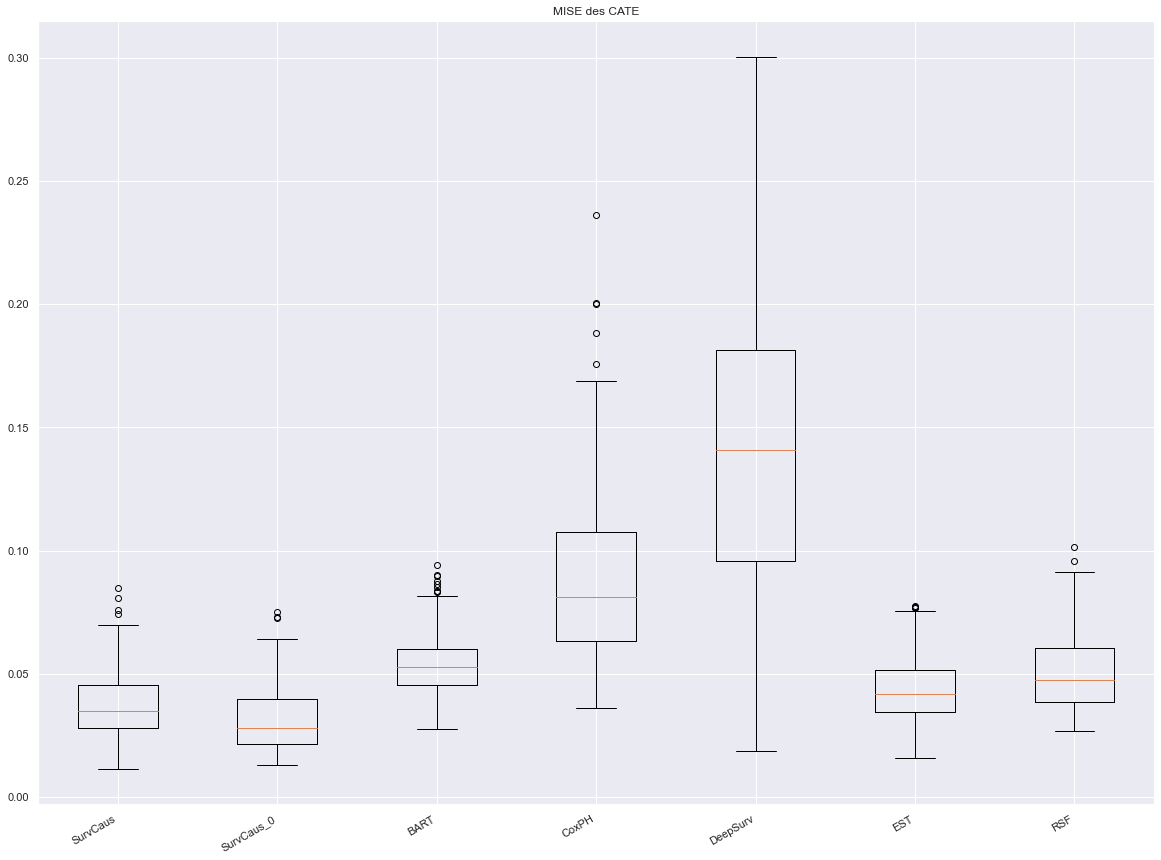

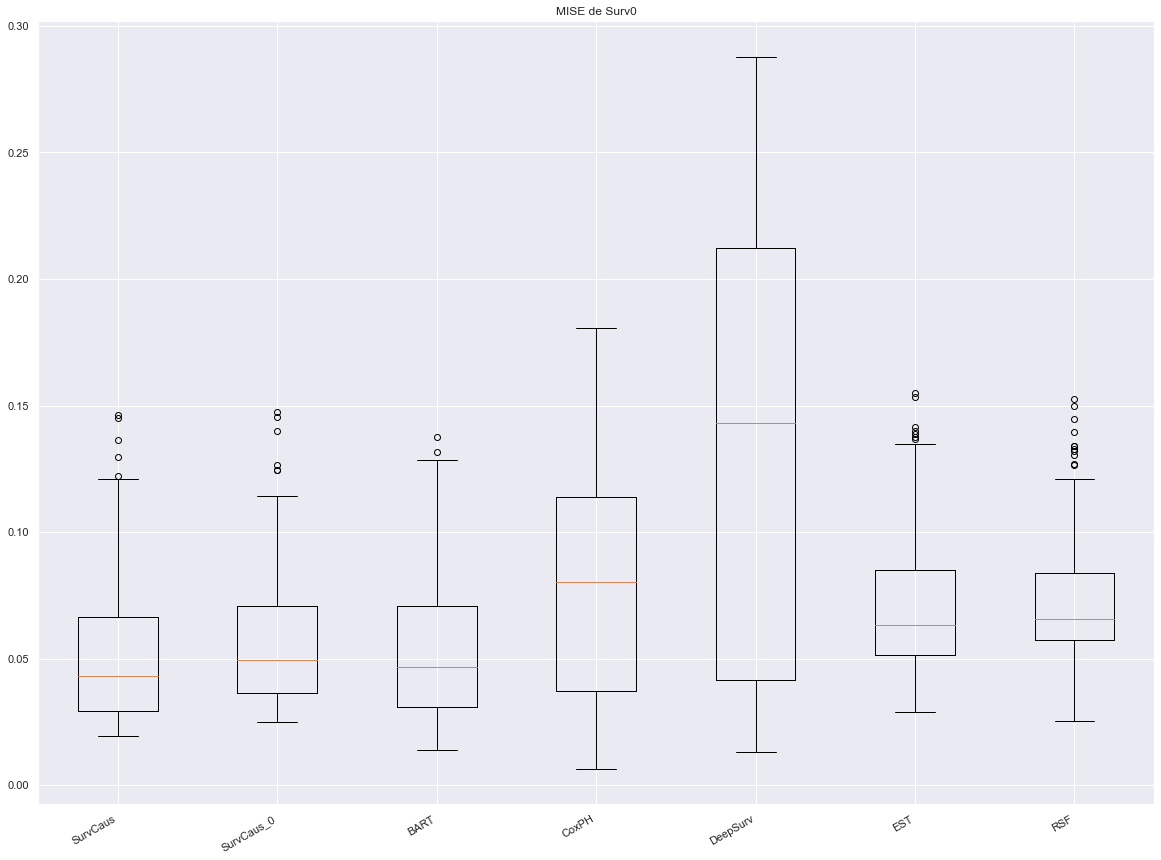

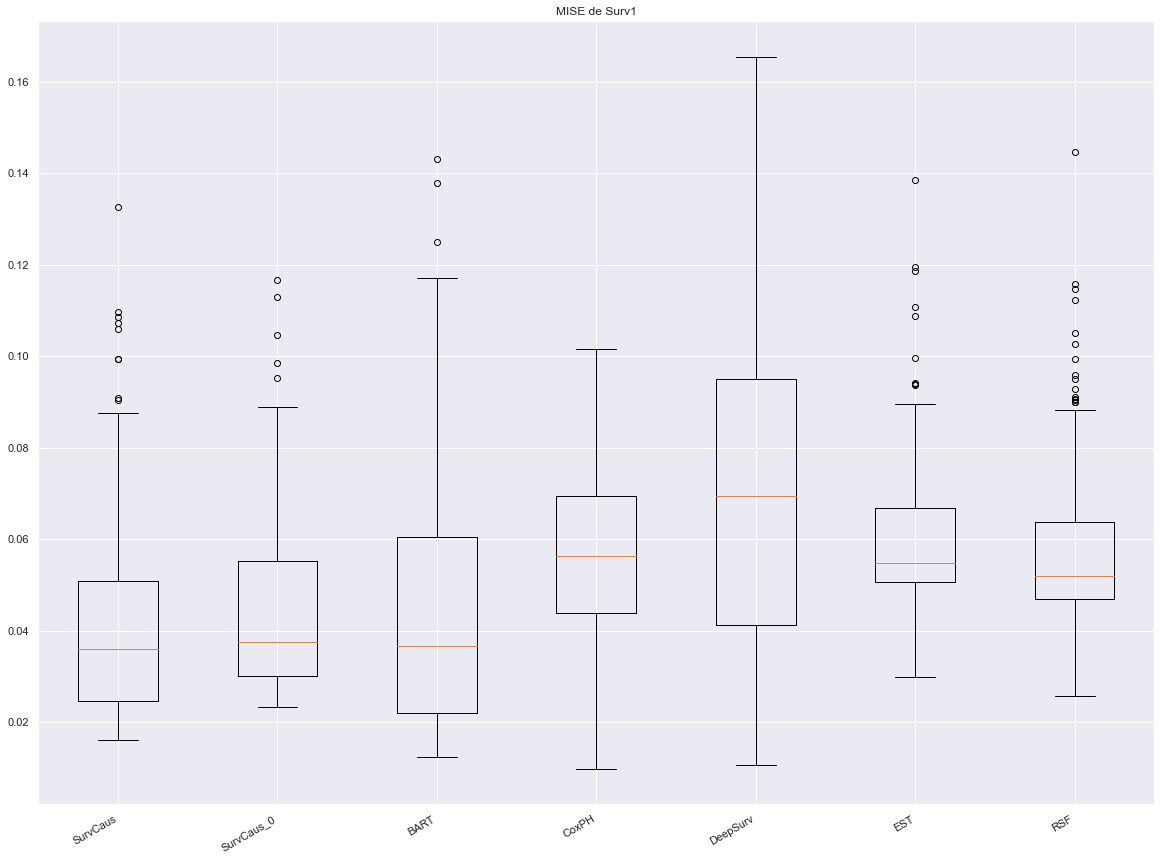

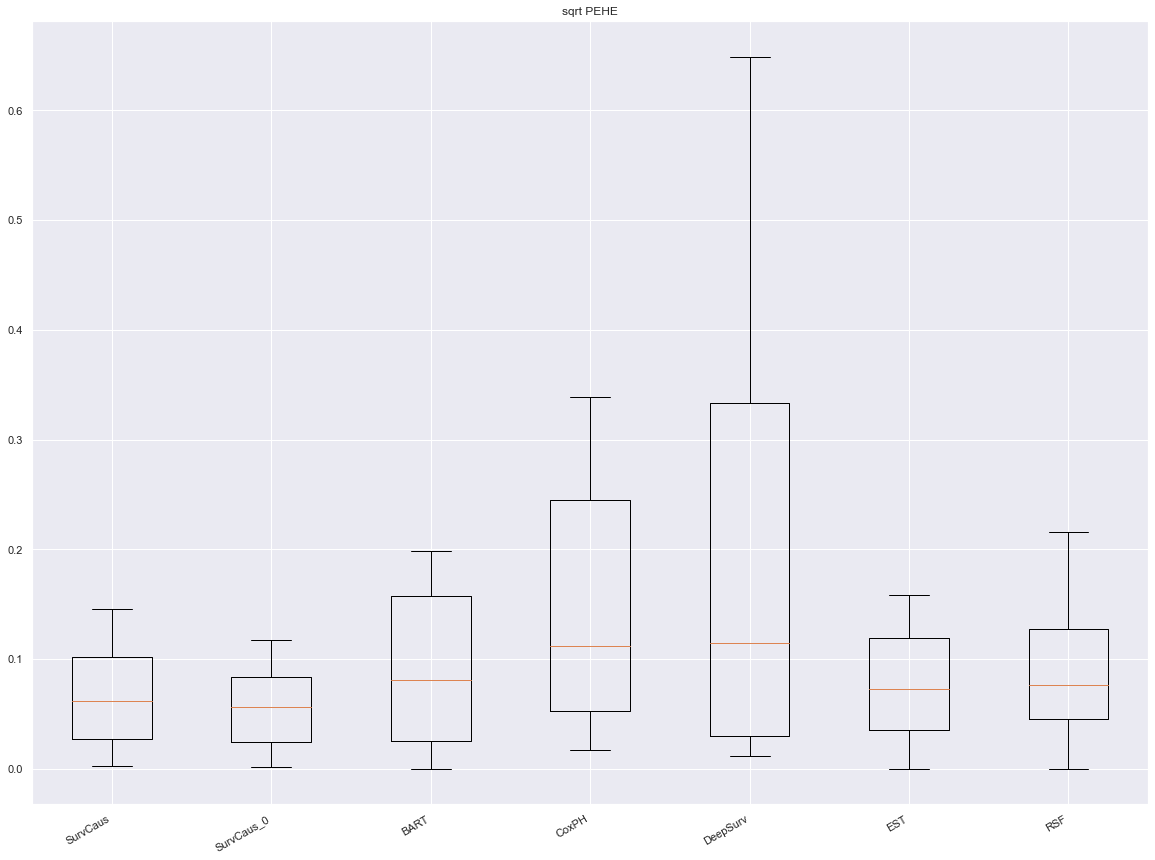

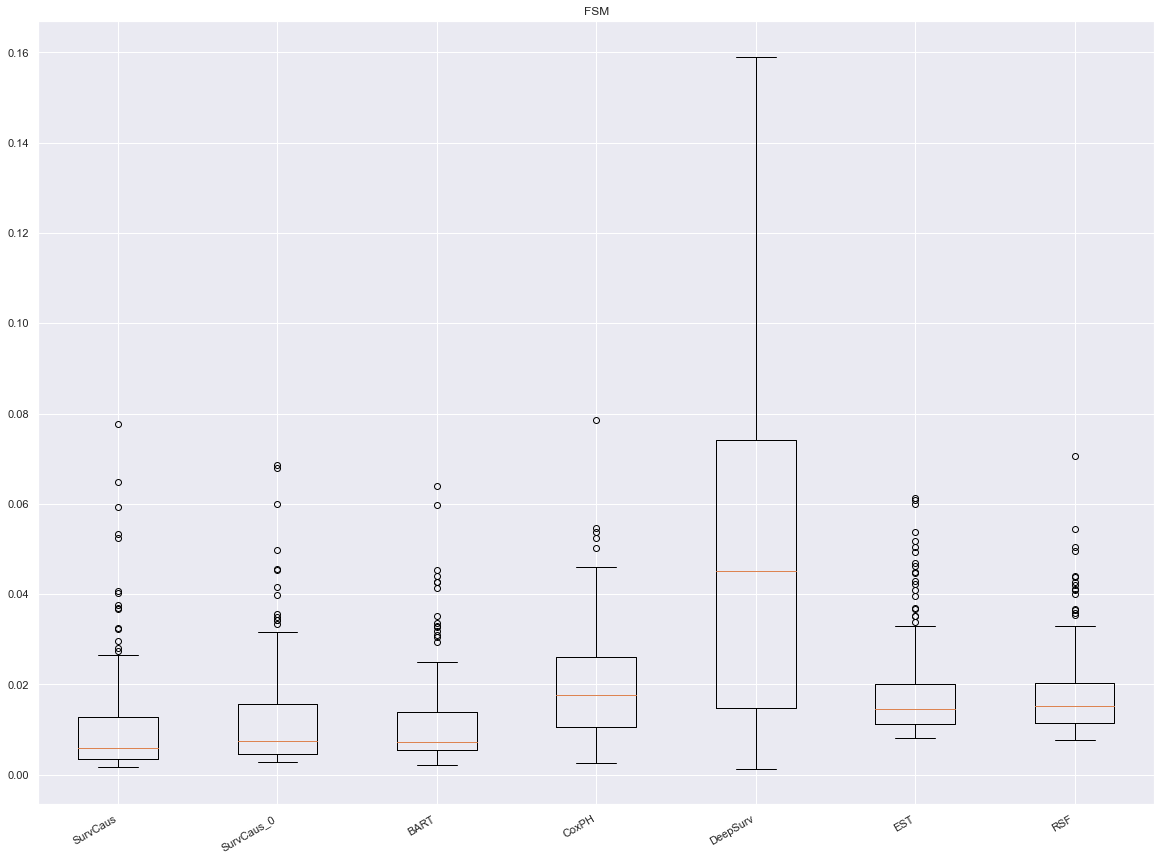

In [13]:
Ev.All_Results(list_models=list_models,
                        is_train=False,params_bart=p_bart_best)

# Benchmark

In [14]:
# Bilan of benchmark
nep.send_data(Ev.bilan_benchmark, "bilan_benchmark",num_run=0)
Ev.bilan_benchmark


,models,Mise0,Mise1,CATE,PEHE,FSM
0,SurvCaus,"(0.051, 0.027)","(0.042, 0.022)","(0.037, 0.014)","(0.065, 0.039)","(0.011, 0.012)"
1,SurvCaus_0,"(0.056, 0.026)","(0.044, 0.018)","(0.032, 0.013)","(0.056, 0.034)","(0.012, 0.011)"
2,BART,"(0.054, 0.028)","(0.045, 0.027)","(0.054, 0.013)","(0.086, 0.063)","(0.011, 0.01)"
3,CoxPH,"(0.077, 0.044)","(0.056, 0.019)","(0.088, 0.034)","(0.147, 0.104)","(0.019, 0.012)"
4,DeepSurv,"(0.132, 0.087)","(0.072, 0.036)","(0.138, 0.059)","(0.204, 0.202)","(0.049, 0.037)"
5,EST,"(0.072, 0.027)","(0.059, 0.018)","(0.044, 0.012)","(0.076, 0.042)","(0.018, 0.011)"
6,RSF,"(0.072, 0.025)","(0.057, 0.019)","(0.05, 0.016)","(0.087, 0.051)","(0.018, 0.01)"


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.005s...
[t-SNE] Computed neighbors for 600 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.113077
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.347111
[t-SNE] KL divergence after 1000 iterations: 0.665562


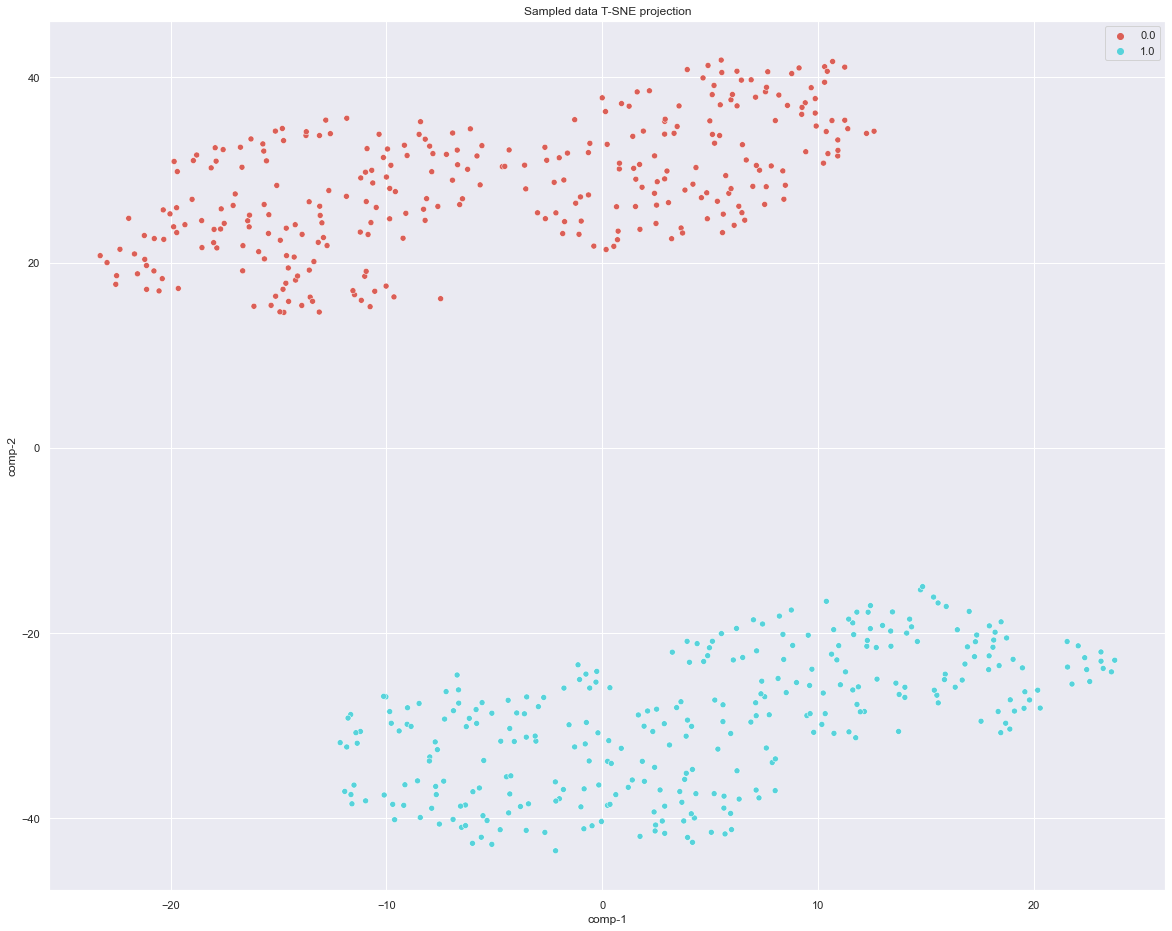

In [15]:
def get_repr(Ev):
    repr = Ev.SC.net.get_repr(torch.tensor(Ev.data.x_train))
    # repr to numpy
    repr = repr.detach().numpy()
    t = Ev.data.x_train[:,-1]
    return repr,t

def tsne_f(repr,t):
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(repr)
    d = pd.DataFrame()
    d["tt"] = t
    d["comp-1"] = z[:, 0]
    d["comp-2"] = z[:, 1]

    fig = plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=d.tt.tolist(),
                palette=sns.color_palette("hls", 2),
                data=d).set(title="Sampled data T-SNE projection")
    plt.close()
    return fig
    
    
repres,t = get_repr(Ev)
tsne_survcaus_final = tsne_f(repres,t)

nep.send_plot(tsne_survcaus_final, "TSNE survcaus final",num_run=0)
tsne_survcaus_final

In [16]:
Ev.box_plot_cate
nep.send_plot(Ev.box_plot_cate, "box_plot_cate",num_run=0)


modifier S,
experiment
log - neptune
tables 
lancer :  wd, lin/nonlin, 
pas oublier brca !! 


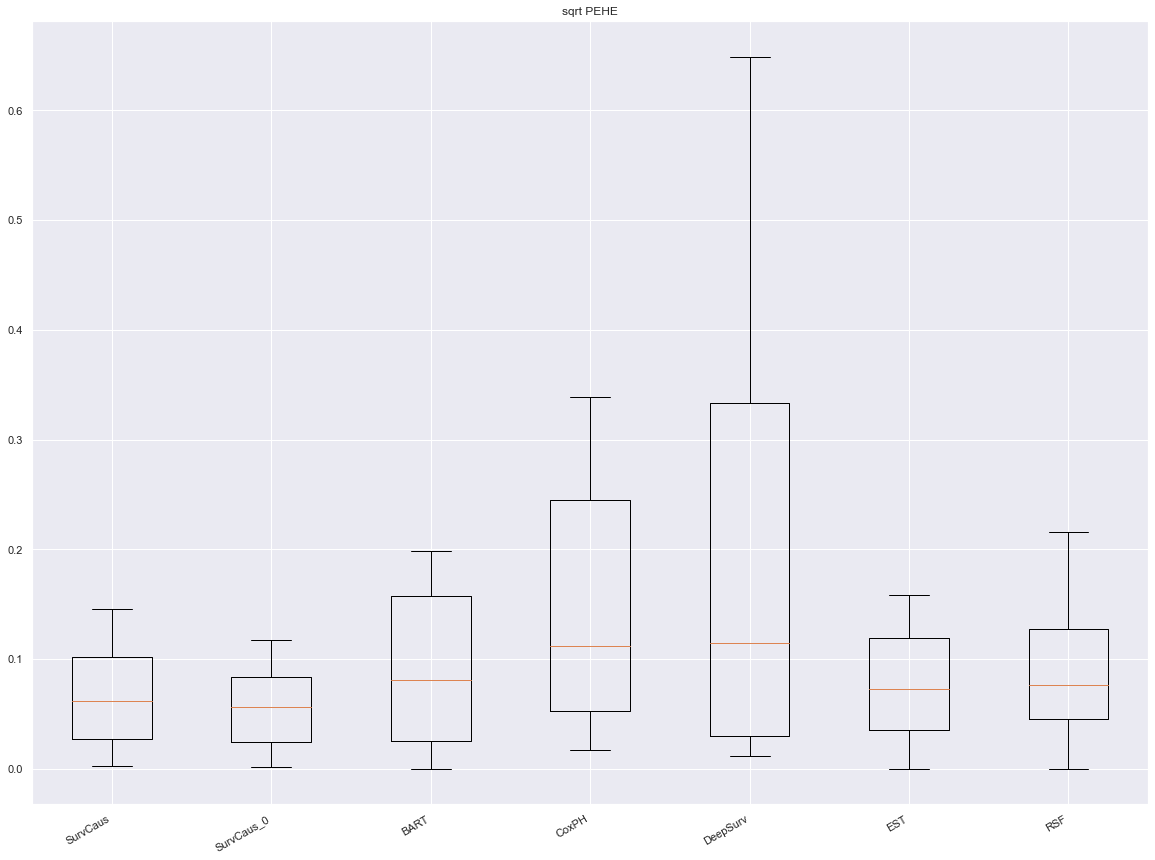

In [17]:
nep.send_plot(Ev.box_plot_pehe, "box_plot_pehe",num_run=0)
Ev.box_plot_pehe


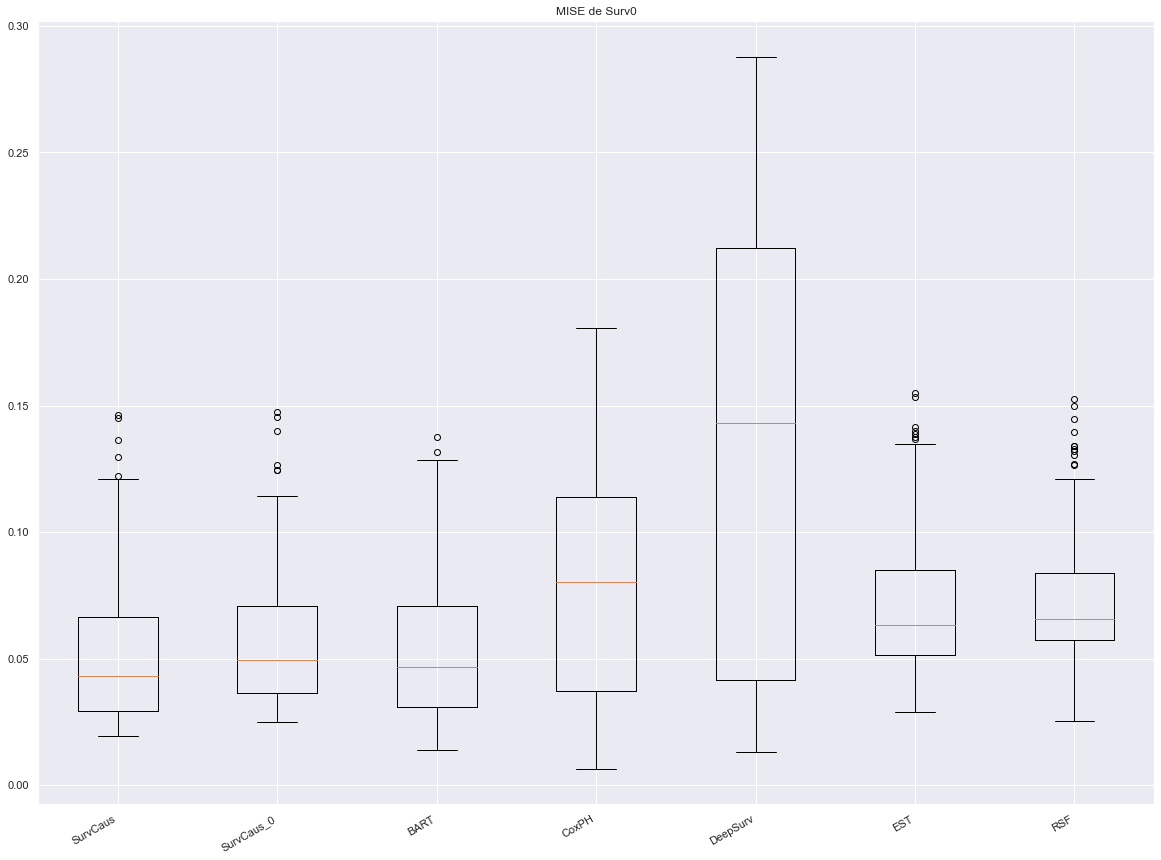

In [18]:
nep.send_plot(Ev.box_plot_surv0, "box_plot_surv0",num_run=0)
Ev.box_plot_surv0


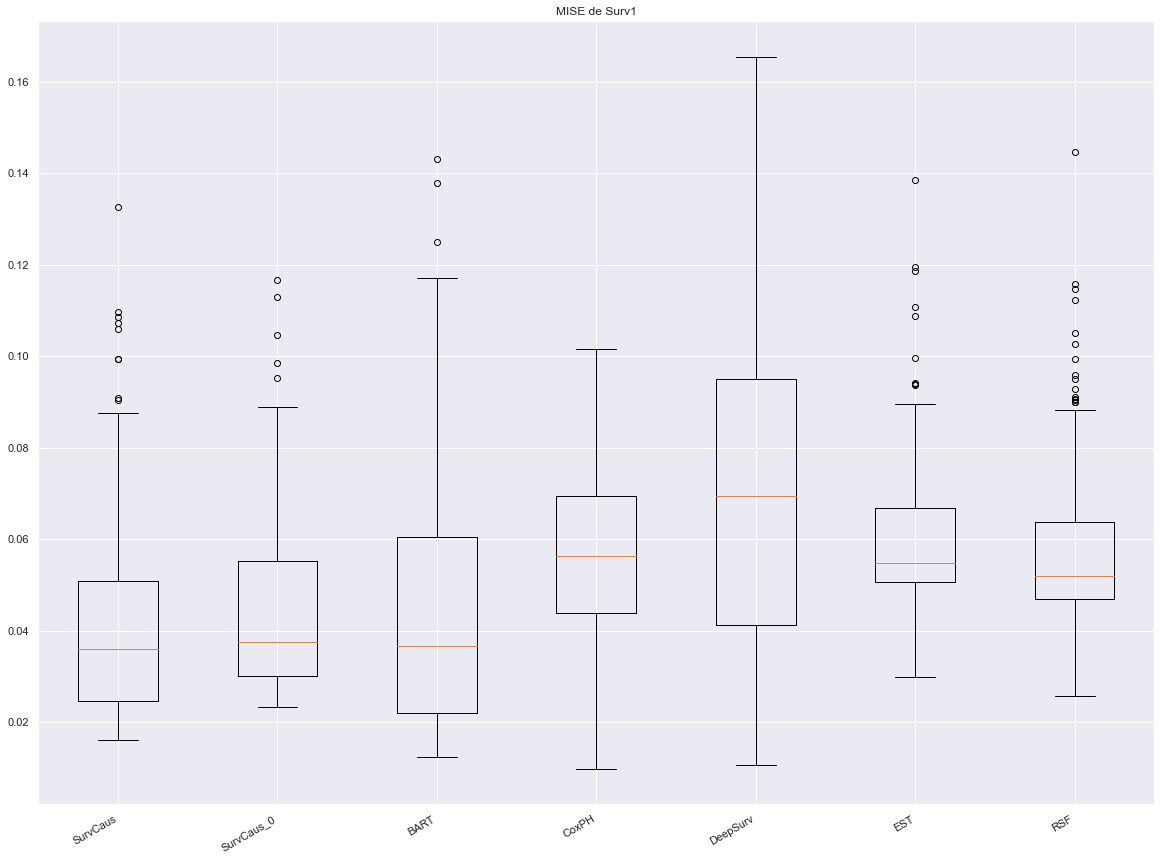

In [19]:
nep.send_plot(Ev.box_plot_surv1, "box_plot_surv1",num_run=0)
Ev.box_plot_surv1


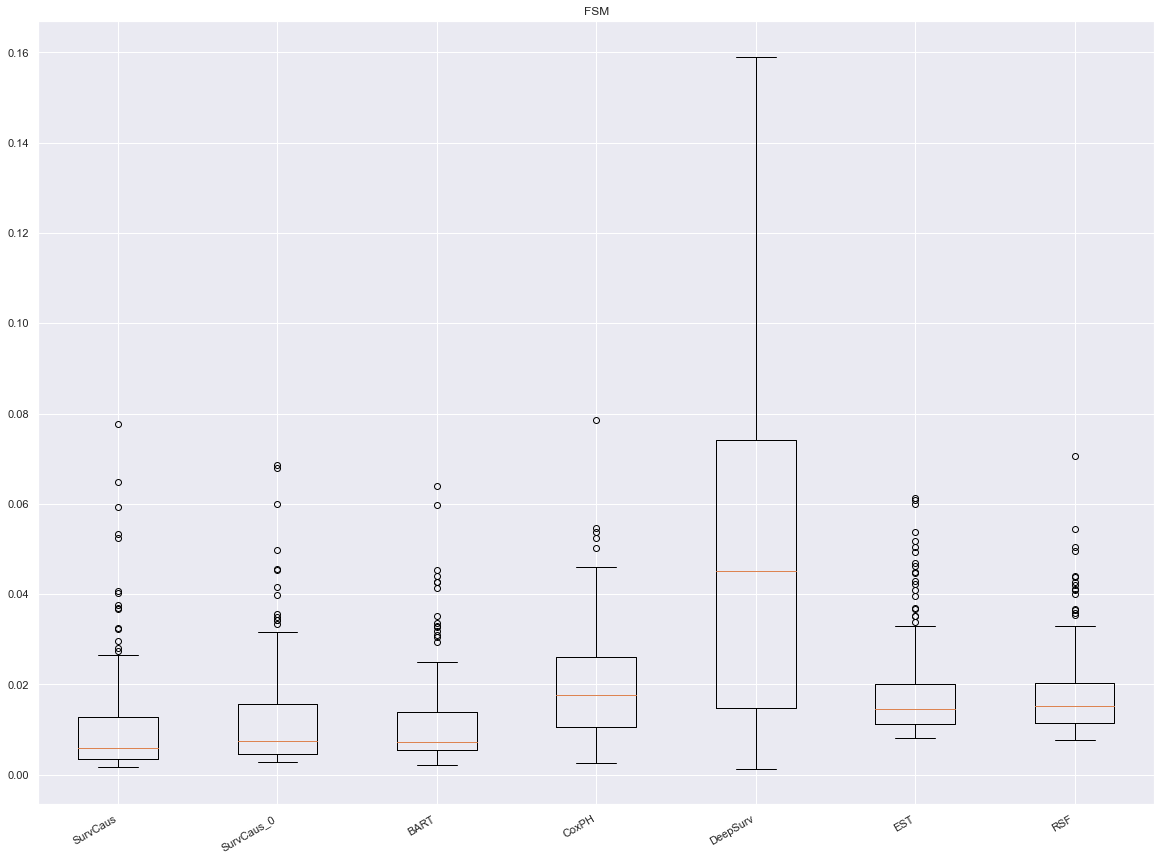

In [20]:
nep.send_plot(Ev.box_plot_FSM, "box_plot_FSM",num_run=0)
Ev.box_plot_FSM


(p_ours,p_bench) = (5, 5)
(p_ours,p_bench) = (5, 60)
(p_ours,p_bench) = (5, 116)
(p_ours,p_bench) = (5, 25)
(p_ours,p_bench) = (5, 81)
(p_ours,p_bench) = (5, 154)
(p_ours,p_bench) = (5, 167)


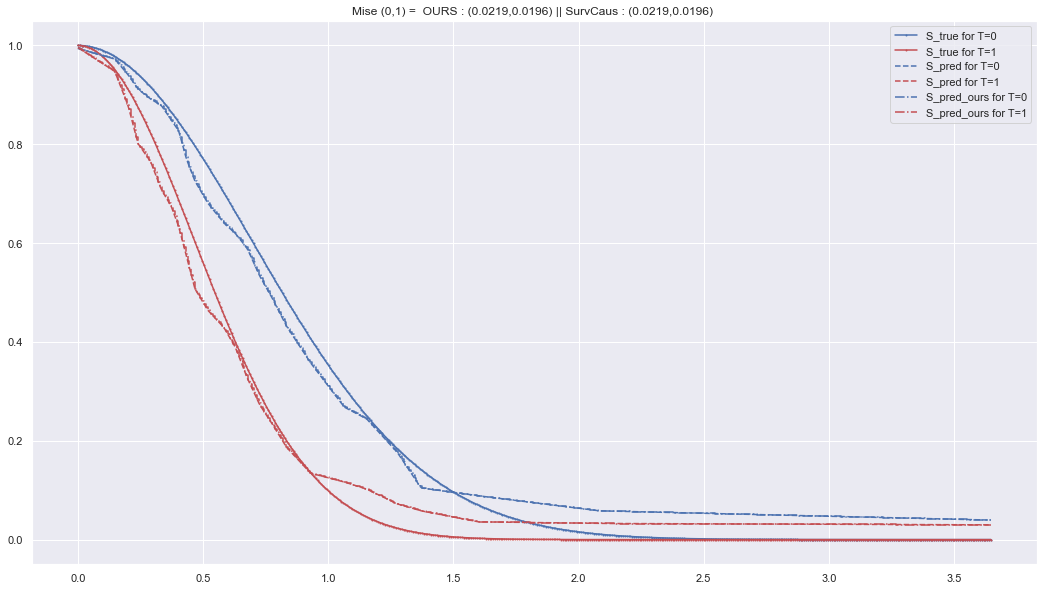

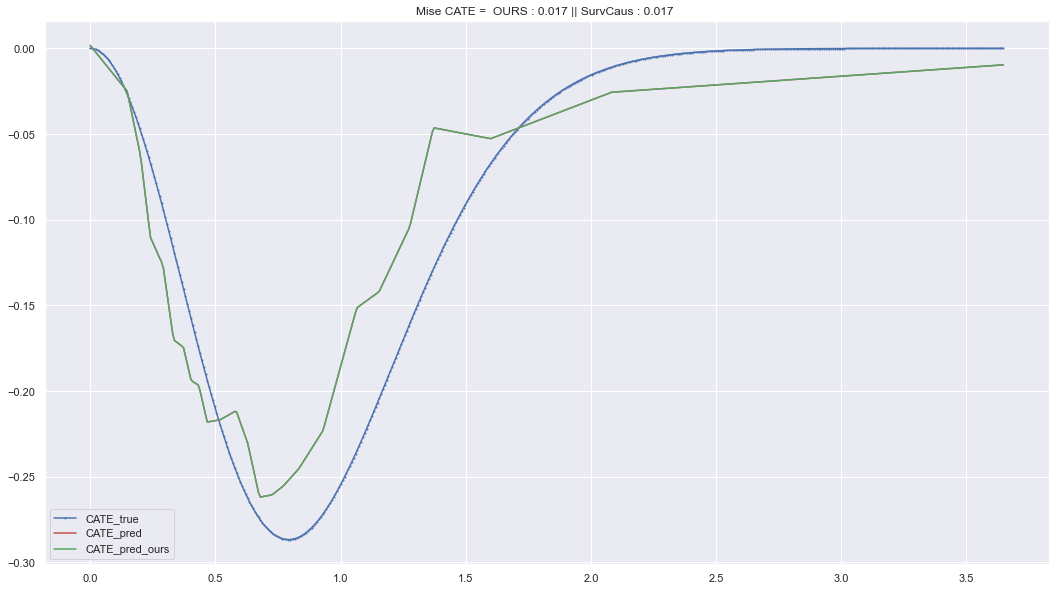

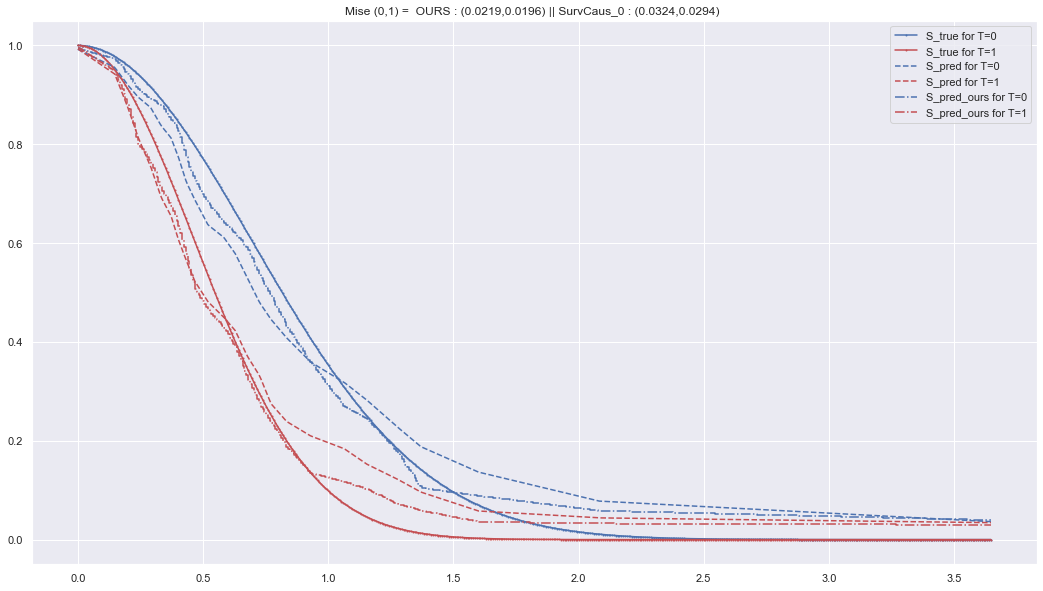

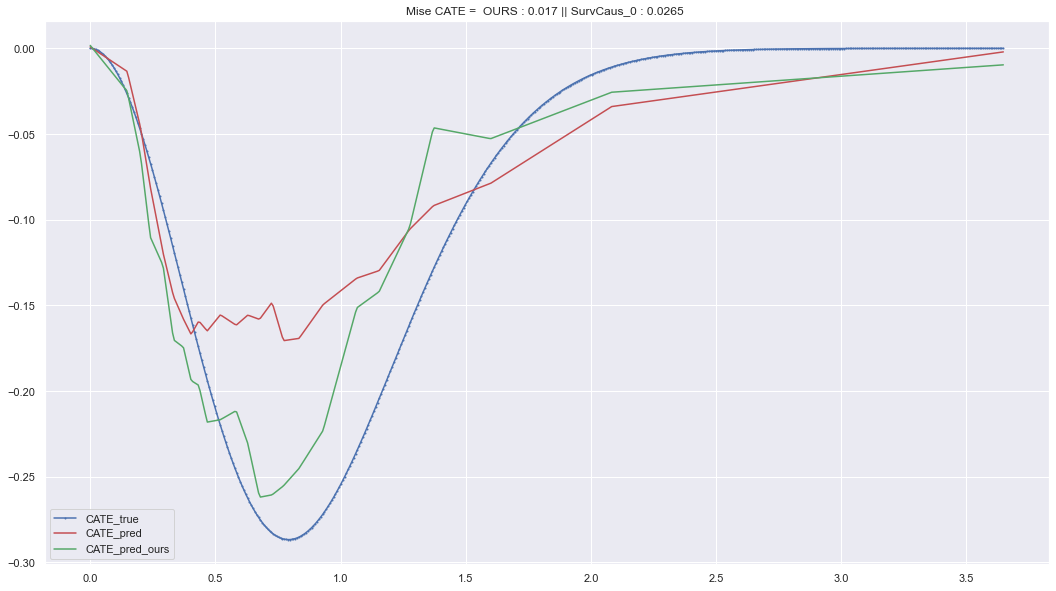

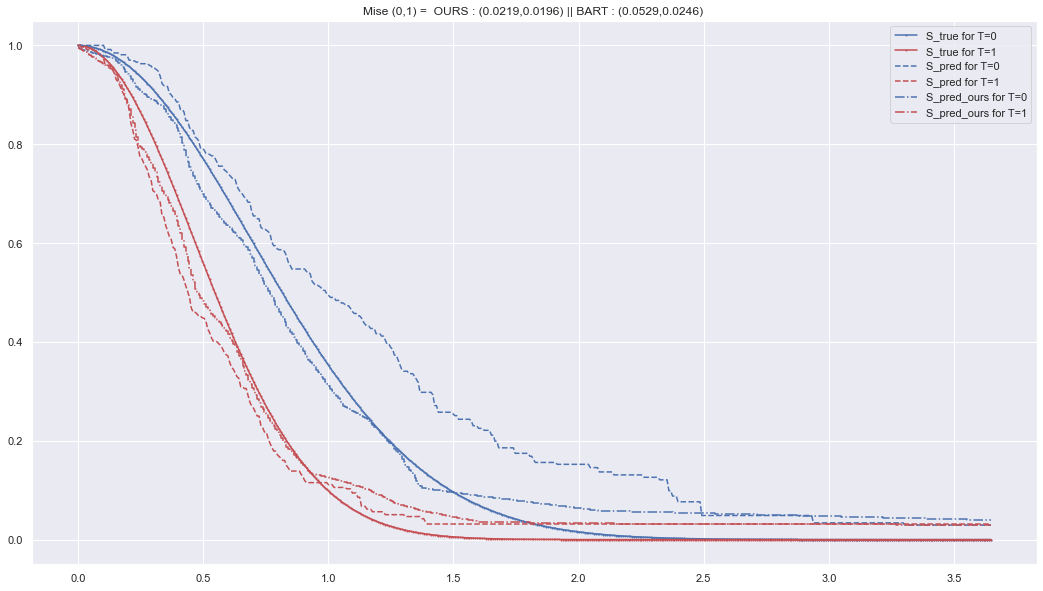

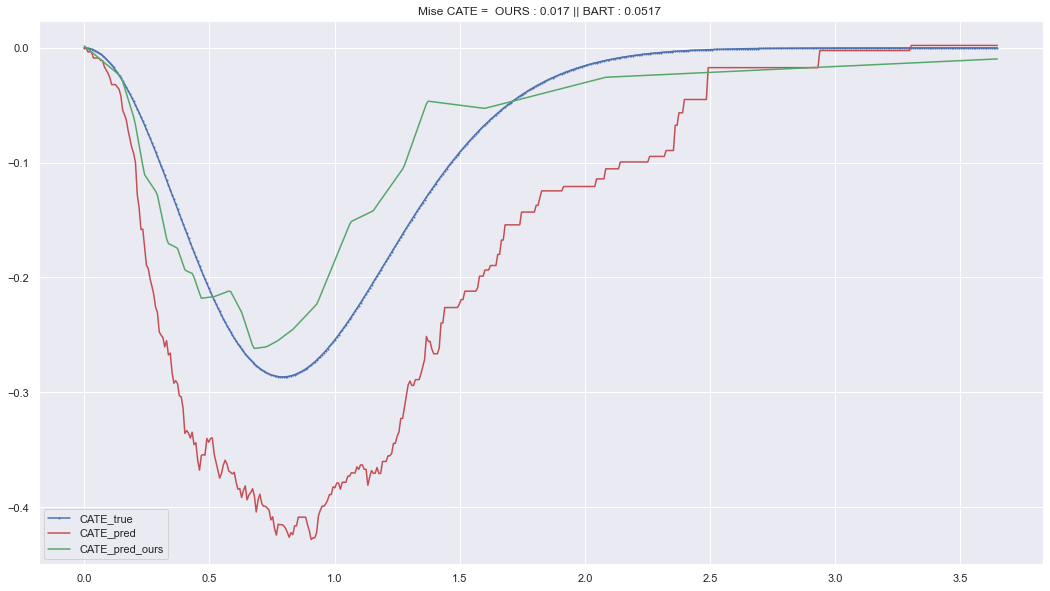

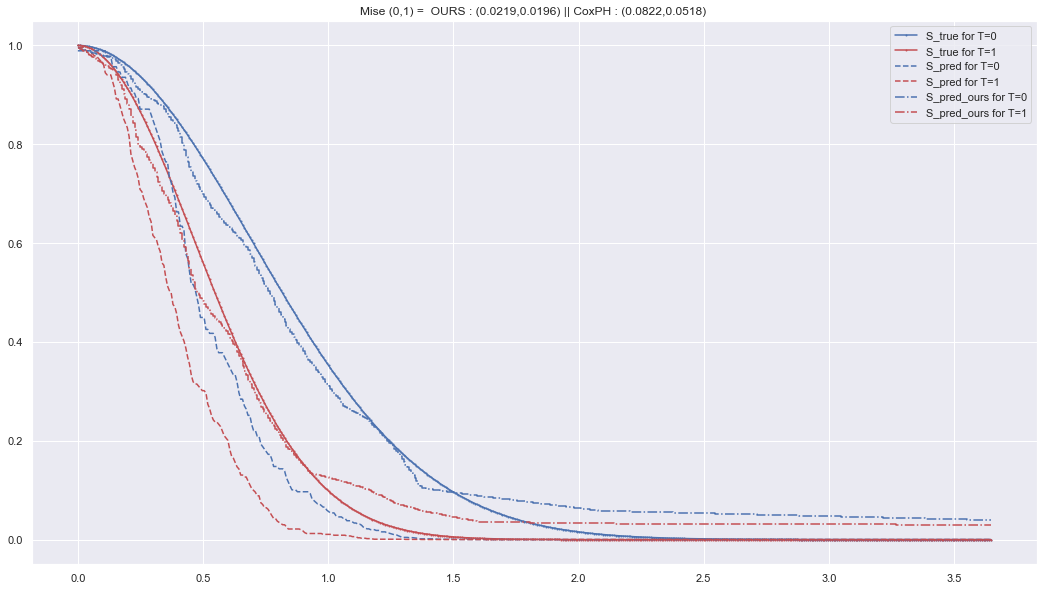

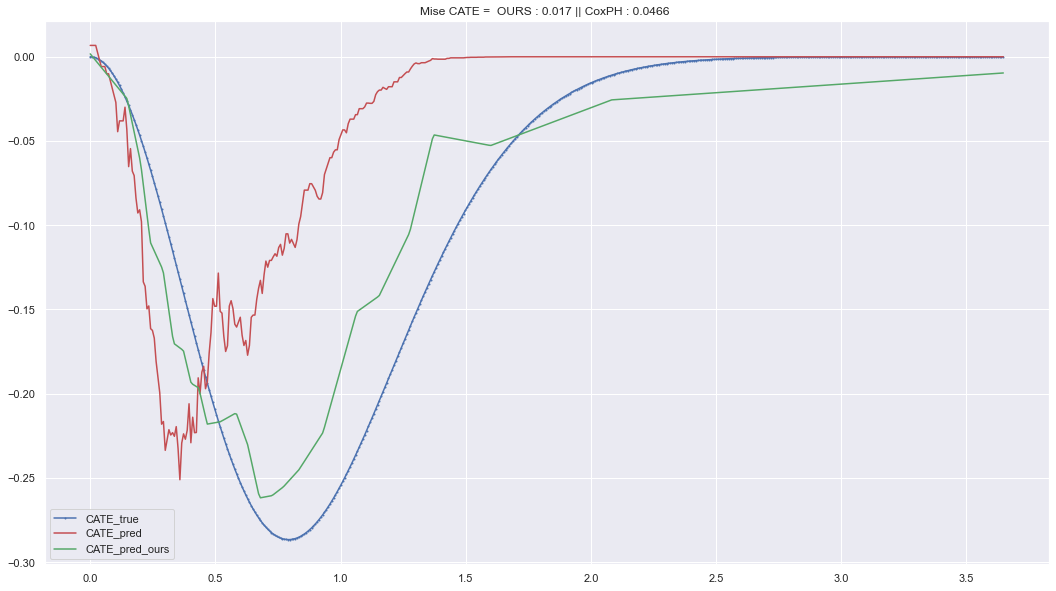

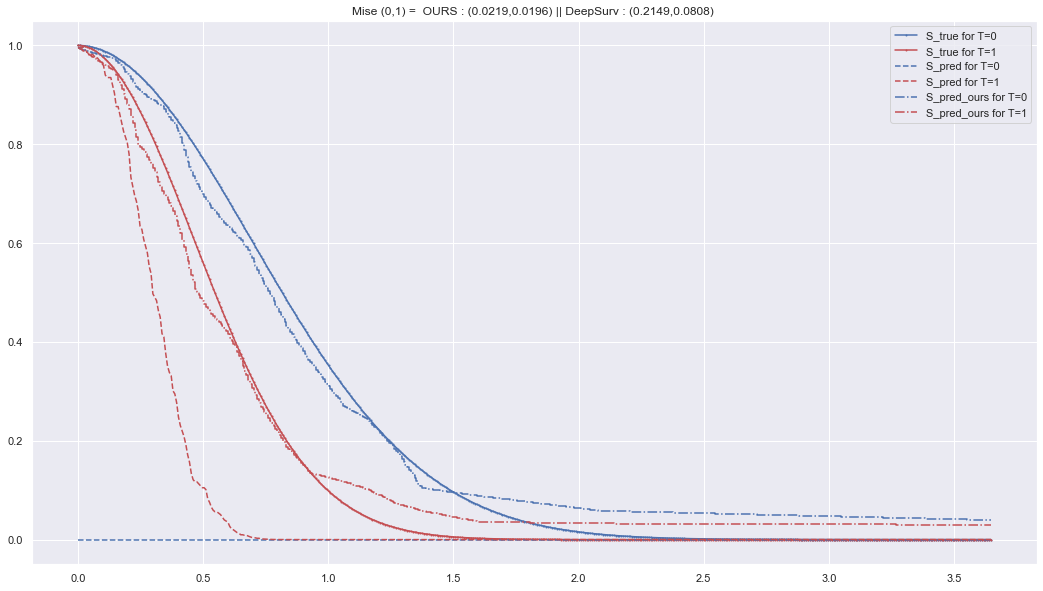

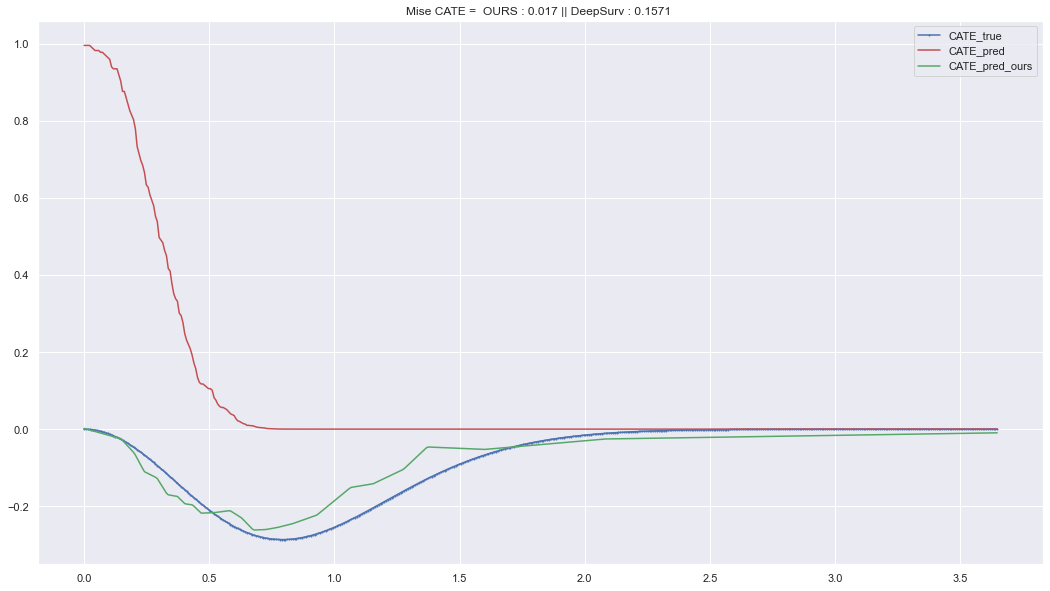

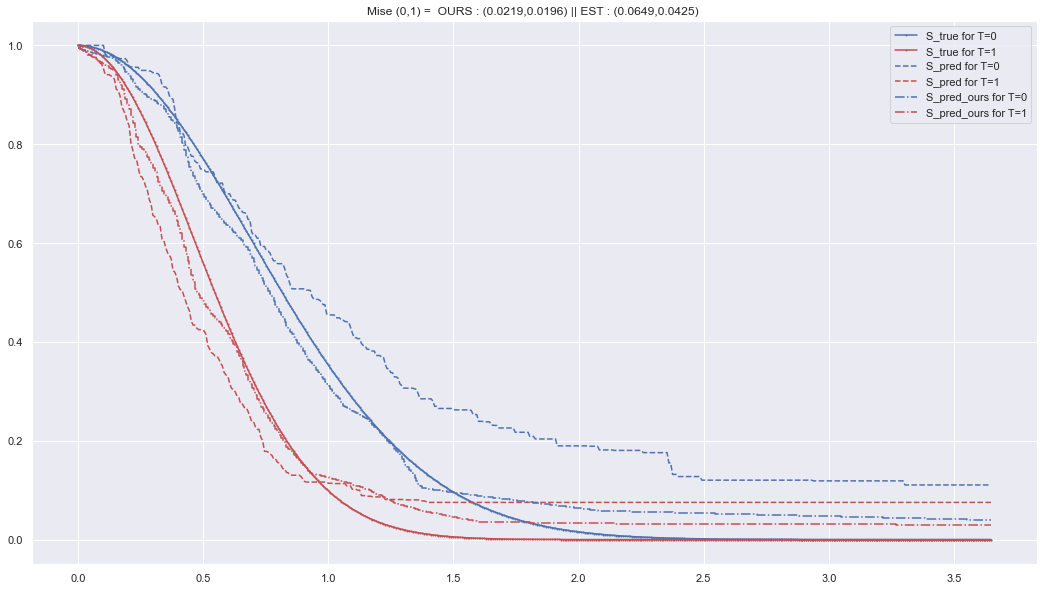

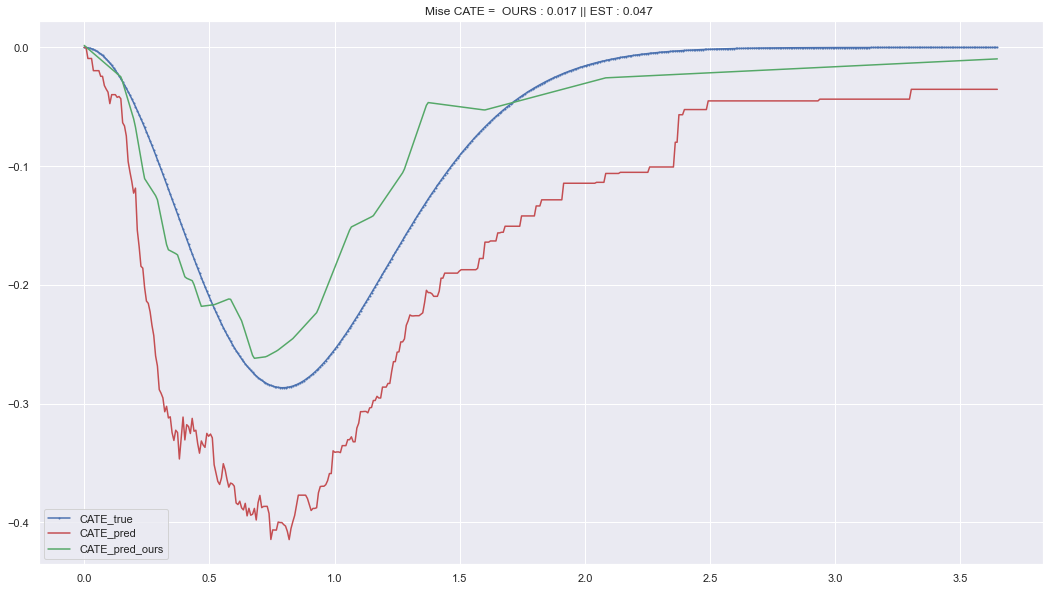

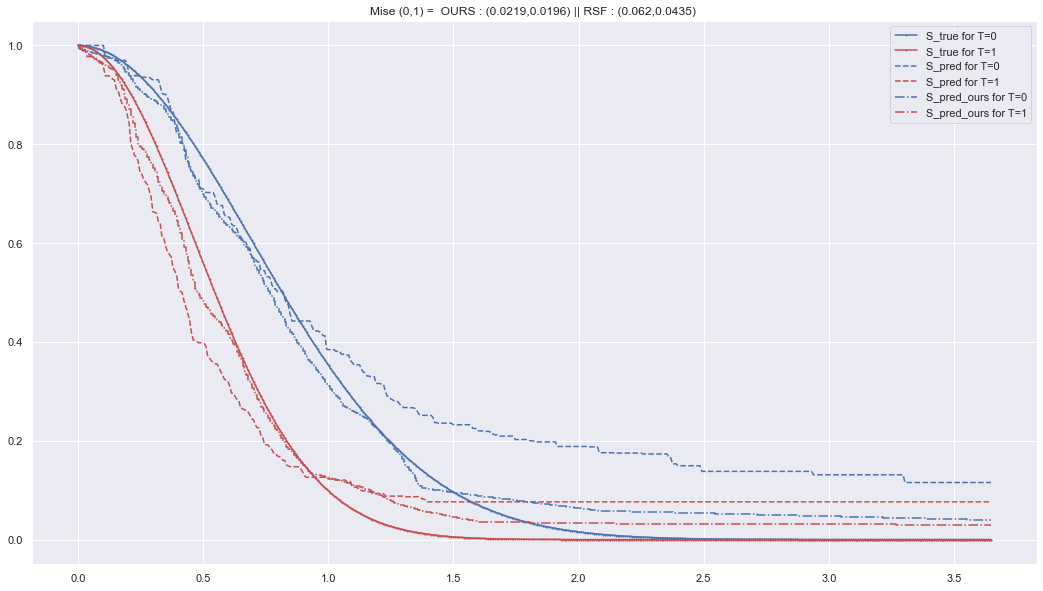

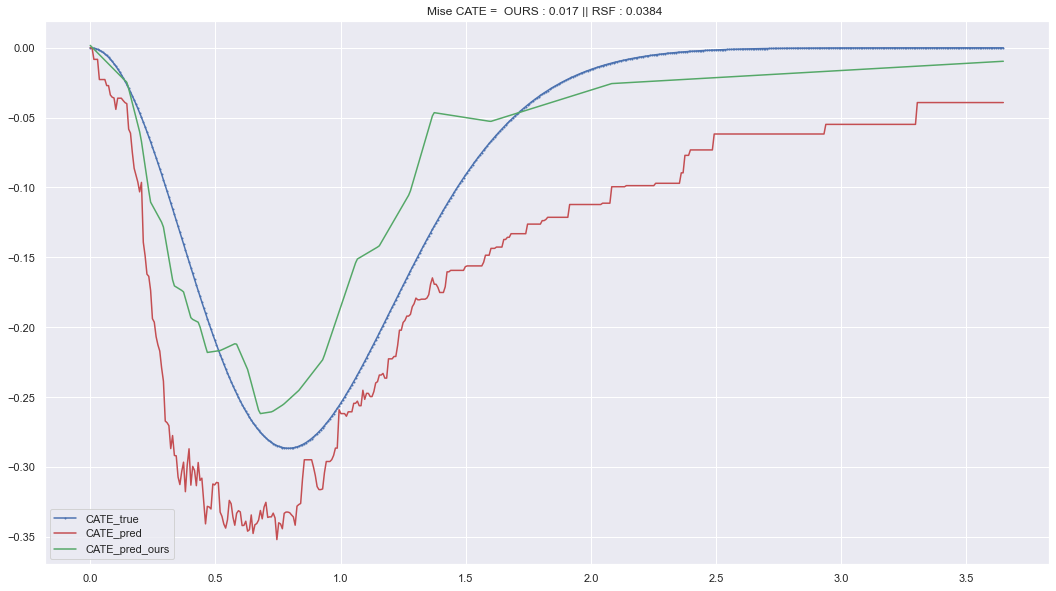

In [23]:

patient = 5
%matplotlib inline
d_q_all = {}
for model_name in Ev.list_models :
    fig_surv,fig_cate,d_q_model = plots(patient, Ev.d_list_models, model_name)
    d_q_all[model_name] = d_q_model
    nep.send_plot(fig_surv, "fig_surv_"+model_name,num_run=0)
    nep.send_plot(fig_cate, "fig_cate_"+model_name,num_run=0)


    



In [24]:

# dataframe of all the quantiles with the model name
df_q = pd.DataFrame(d_q_all)
nep.send_data(df_q, "df_q",num_run=0)
df_q


,SurvCaus,SurvCaus_0,BART,CoxPH,DeepSurv,EST,RSF
p,"[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]","[0.1, 0.25, 0.4, 0.5, 0.75, 0.9]"
t*_0 true,"[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]","[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]","[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]","[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]","[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]","[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]","[1.49, 1.15, 0.94, 0.82, 0.53, 0.32]"
t*_0 pred,"[1.44, 1.13, 0.88, 0.77, 0.45, 0.27]","[1.9, 1.23, 0.85, 0.71, 0.42, 0.23]","[2.36, 1.51, 1.23, 0.99, 0.58, 0.37]","[0.86, 0.68, 0.55, 0.47, 0.35, 0.22]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.3, 1.58, 1.13, 0.93, 0.49, 0.37]","[3.3, 1.37, 0.98, 0.8, 0.45, 0.34]"
dif_0,0.05462,0.189253,0.409166,0.394715,0.95585,0.765212,0.745352
t*_1 true,"[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]","[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]","[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]","[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]","[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]","[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]","[0.99, 0.77, 0.63, 0.55, 0.35, 0.21]"
t*_1 pred,"[1.16, 0.75, 0.61, 0.48, 0.3, 0.18]","[1.36, 0.81, 0.65, 0.5, 0.29, 0.18]","[1.07, 0.72, 0.55, 0.44, 0.28, 0.18]","[0.7, 0.53, 0.42, 0.37, 0.23, 0.15]","[0.51, 0.4, 0.34, 0.3, 0.21, 0.15]","[1.12, 0.69, 0.52, 0.42, 0.24, 0.17]","[1.13, 0.69, 0.48, 0.42, 0.25, 0.17]"
dif_1,0.079582,0.155938,0.074386,0.19841,0.299193,0.104881,0.113284
dif,0.067101,0.172595,0.241776,0.296563,0.627522,0.435047,0.429318
